In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import nltk

from matplotlib.image import imread

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from IPython.display import display, HTML

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import MaxPooling2D, Flatten
from keras import Model
from keras.preprocessing.image import load_img, img_to_array

from gensim.models import Word2Vec

# Chargement et prise en main des données disponibles

In [2]:
data = pd.read_csv('Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv',
                   parse_dates=['crawl_timestamp'])

In [6]:
data.head(5)

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52+00:00   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [7]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   uniq_id                  1050 non-null   object             
 1   crawl_timestamp          1050 non-null   datetime64[ns, UTC]
 2   product_url              1050 non-null   object             
 3   product_name             1050 non-null   object             
 4   product_category_tree    1050 non-null   object             
 5   pid                      1050 non-null   object             
 6   retail_price             1049 non-null   float64            
 7   discounted_price         1049 non-null   float64            
 8   image                    1050 non-null   object             
 9   is_FK_Advantage_product  1050 non-null   bool               
 10  description              1050 non-null   object             
 11  product_rating           1050 

**==> Aucune NaN dans les variables à utiliser (i.e. product_category_tree, image, description)**

# Sélection des catégories à utiliser ('product_category_tree')
= catégories "vraies" / étiquettes "réelles" à comparer avec clusters qu'on aura obtenus de manière non supervisée pour évaluation performances / faisabilité

In [3]:
# aperçu de quelques individus
for i in range (0,11,1):
    print(data.product_category_tree[i])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]
["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]
["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]
["Watches >> Wrist Watches >> Camerii Wrist Watches"]
["Watches >> Wrist Watches >> T STAR Wrist Watches"]
["Watches >> Wrist Watches >> Alfajr Wrist Watches"]
["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]
["Watches >> Wrist Watches >> Calibro Wrist Watches"]


In [4]:
# détermination du nombre de catégories pour chaque article
data['nb_categ'] = data['product_category_tree'].apply(lambda x: x.count('>>')+1)

# détermination du nombre MAX de catégories par article
nb_max_categ = max(data.nb_categ)
print('Le nombre maximal de catégories est ', nb_max_categ)

# pour info: détermination du nombre MIN de catégories par article
nb_min_categ = min(data.nb_categ)
print('Le nombre minimal de catégories est ', nb_min_categ)

Le nombre maximal de catégories est  7
Le nombre minimal de catégories est  2


In [5]:
# Séparer les différents niveaux de catégories: un niveau par colonne
    # enlever les '["' et '"]'
data['product_category_tree'] = data['product_category_tree'].str.replace('\["', '')
data['product_category_tree'] = data['product_category_tree'].str.replace('"\]', '')
print('vérif 1: ', data.product_category_tree[5])
    # créer une liste des catégories
data['product_category_tree'] = data['product_category_tree'].str.split(' >> ')
print('vérif 2a: ', data.product_category_tree[5])
print('vérif 2b: ', data.product_category_tree[5][0])
    # création des colonnes des différents niveaux de catégories
for i in range (0, nb_max_categ, 1):
    data['categ{}'.format(i+1)] = data.product_category_tree.apply(lambda x: x[i] if len(x) >= i+1 else np.nan)
print('vérif 3: ', data.iloc[5,-8:])

vérif 1:  Watches >> Wrist Watches >> Maserati Time Wrist Watches
vérif 2a:  ['Watches', 'Wrist Watches', 'Maserati Time Wrist Watches']
vérif 2b:  Watches
vérif 3:  nb_categ                              3
categ1                          Watches
categ2                    Wrist Watches
categ3      Maserati Time Wrist Watches
categ4                              NaN
categ5                              NaN
categ6                              NaN
categ7                              NaN
Name: 5, dtype: object


In [11]:
# Vérif sur plusieurs individus
for i in range (0,11,1):
    print(data.iloc[i, -8:])
    print('-' * 20)

nb_categ                                                    4
categ1                                        Home Furnishing
categ2                                 Curtains & Accessories
categ3                                               Curtains
categ4      Elegance Polyester Multicolor Abstract Eyelet ...
categ5                                                    NaN
categ6                                                    NaN
categ7                                                    NaN
Name: 0, dtype: object
--------------------
nb_categ                                                    5
categ1                                              Baby Care
categ2                                       Baby Bath & Skin
categ3                                       Baby Bath Towels
categ4                              Sathiyas Baby Bath Towels
categ5      Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...
categ6                                                    NaN
categ7                    

----------------------------------------------------------------------------------------------------
categ1
--------------------
nb unique val =  7
--------------------
<bound method Series.cumsum of Home Decor & Festive Needs    150
Beauty and Personal Care      150
Baby Care                     150
Kitchen & Dining              150
Watches                       150
Home Furnishing               150
Computers                     150
Name: categ1, dtype: int64>
--------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
categ2
--------------------
nb unique val =  62
--------------------
--------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
categ3
------------

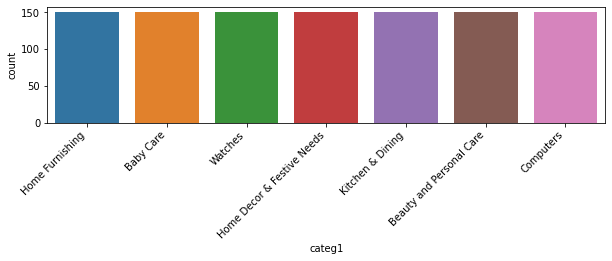

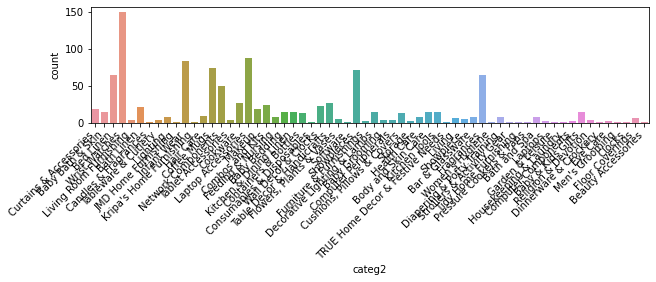

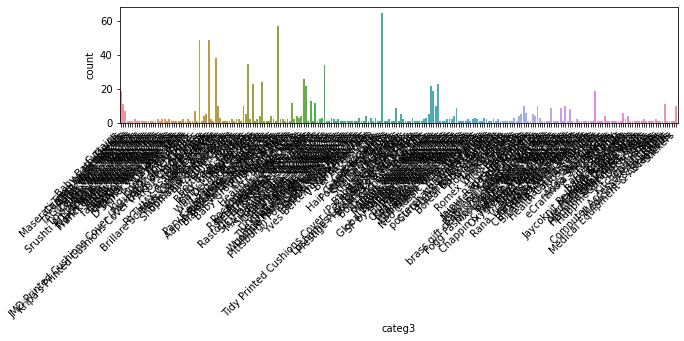

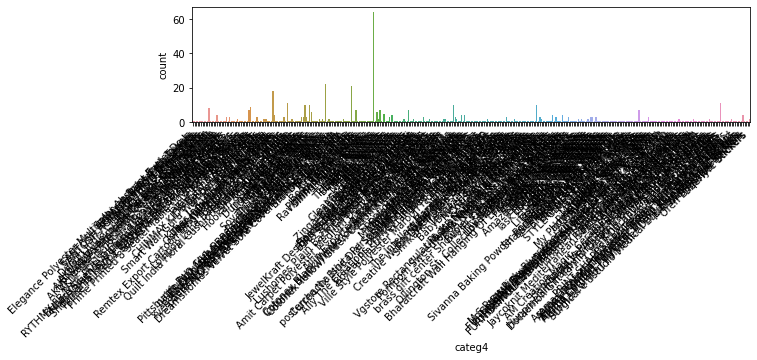

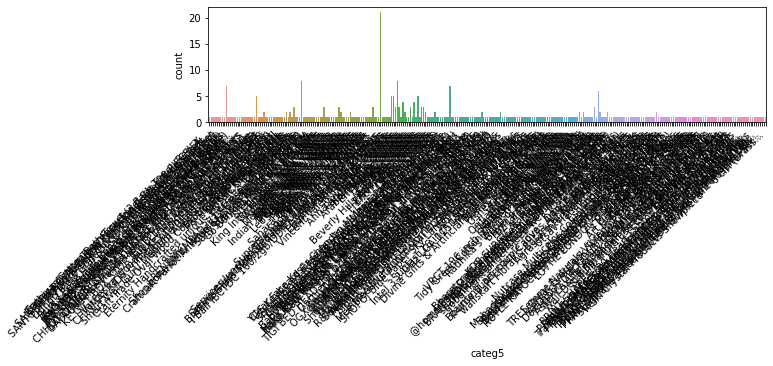

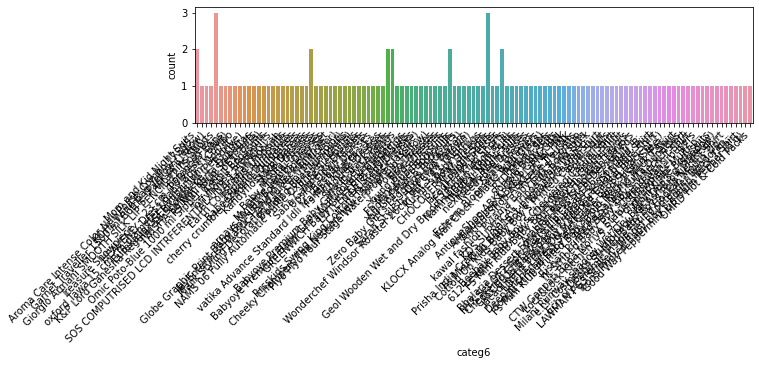

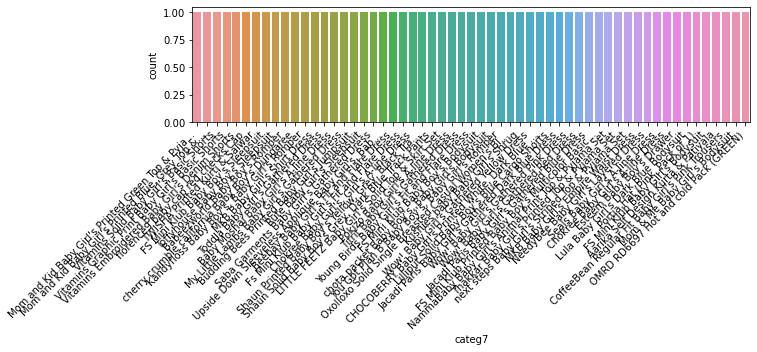

In [12]:
# Visualisation distrbution des catégories par niveau
for i in range (0, nb_max_categ, 1):
    for categ in ['categ{}'.format(i+1)]:
        print('-' * 100)
        print(categ)
        print('-' * 20)
        print('nb unique val = ', data[categ].nunique())
        print('-' * 20)
        if data[categ].nunique() < 20:
            print(data[categ].value_counts().cumsum)
        print('-' * 20)
        fig = plt.figure(figsize=(10, 20))
        ax = fig.add_subplot(8,1, i+1)
        g = sns.countplot(x=categ, data=data)
        g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
        print('-' * 100)

**==> Nos "catégories vraies" / étiquettes réelles seront les 7 catégories de niveau 1 (équilibrées, i.e. homogènes en termes de nb d'articles par catégorie de ce niveau) -- on cherchera donc idéalement à partitionner de manière non-supervisée notre jeu de données en 7 catégories**

Remarques : catégories niveau 2 non homogènes -- perte d'individus avec l'utilisation des autres niveaux de catégorie 

## Aperçu détaillé des éléments à utiliser

### Images

In [6]:
def list_fct(categ) :
    '''Fonction pour créer une liste rassemblant
    les images d'une même catégorie de niveau 1'''
    list_image_categ = [data.image[i] for i in range(data.shape[0]) if data['categ1'][i] == categ]
    return list_image_categ

# Création des 7 listes (une par categorie de niveau 1)
list_HomeDecor_Festive_Needs = list_fct("Home Decor & Festive Needs")
list_Watches = list_fct("Watches")
list_Computers = list_fct("Computers")
list_Kitchen_Dining = list_fct("Kitchen & Dining")
list_Beauty_PersonalCare = list_fct("Beauty and Personal Care")
list_BabyCare = list_fct("Baby Care")
list_HomeFurnishing = list_fct("Home Furnishing")

# path vers dossier images
path = "./Dataset+projet+prétraitement+textes+images/Flipkart/Images/"

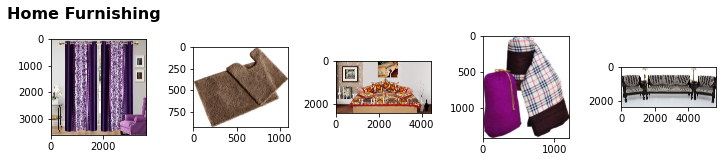

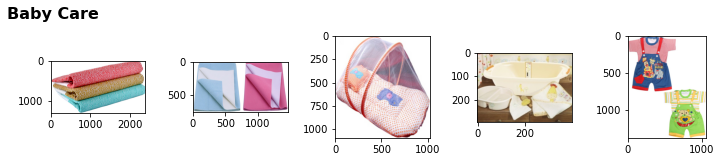

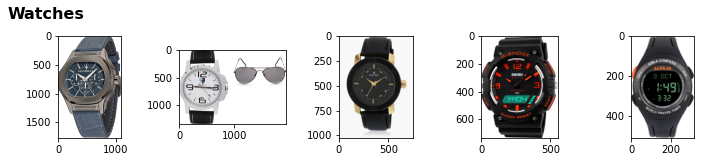

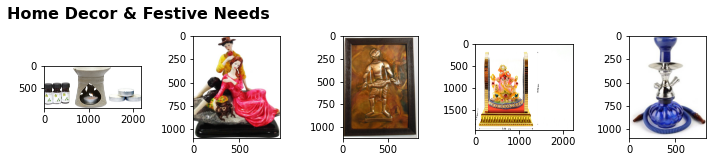

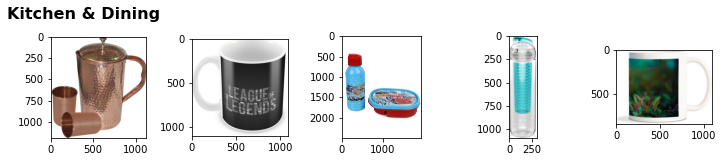

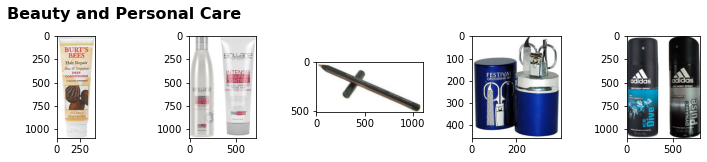

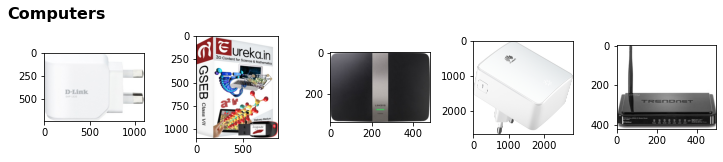

In [14]:
# Affichage de 5 photos par catégorie
for categ in data['categ1'].unique().tolist() :
    fig = plt.figure(figsize=(10,2))
    fig.suptitle(categ, fontweight='bold', fontsize=16, y=1.1, x=0, ha='left')
    for i in range(5):
        ax = fig.add_subplot(1,5,i+1)
        filename = path + list_fct(categ)[i*5]
        image = imread(filename)
        ax.imshow(image)
        #ax.set_axis_off()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

### Descriptions

In [19]:
# Affichage d'exemples de descriptions par catégorie de niveau 1
for categ in data['categ1'].unique().tolist() :
    print('-' * 100)
    print(categ)
    for i in range (0, 5, 1):
        print('-' * 20)
        print('(', i+1, ')')
        print(data[data['categ1'] == categ].description.iloc[i*5])
    print('-' * 100)

----------------------------------------------------------------------------------------------------
Home Furnishing
--------------------
( 1 )
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most s

# Traitement des IMAGES des produits via SIFT

## Pré-traitements & Exemples de descripteurs sur une image de chaque catégorie
Plusieurs pré-traitements testés, avec visualisation sur 1ère image de chaque catégorie de niveau 1 effectuée -- UN SEUL EXEMPLE MONTRE ICI pour réduire la taille du notebook

Watches


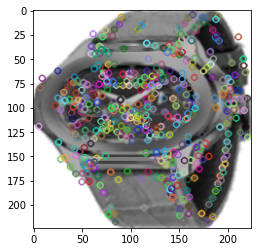

Descripteurs :  (500, 128)

[[ 4.  4.  2. ...  0.  0.  0.]
 [12. 13.  1. ...  0.  0.  4.]
 [38. 58.  0. ...  0.  0.  0.]
 ...
 [13.  6. 18. ...  2.  4.  1.]
 [89.  2.  3. ...  0.  0. 17.]
 [ 8. 11. 29. ...  0.  1.  4.]]
----------------------------------------------------------------------------------------------------


In [8]:
# Visualisation descripteurs sur Prétraitements v1 avec nb descripteurs = 500

#for categ in data['categ1'].unique().tolist() :
for categ in ["Watches"]:
    print(categ)
    sift = cv2.SIFT_create(500)
    image = imread(path + list_fct(categ)[0]) # load image
    image = cv2.resize(image, (224,224), interpolation = cv2.INTER_LINEAR) # resize it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grey
    image = cv2.equalizeHist(image)   # equalize its histogram
    image = cv2.GaussianBlur(image, (3,3), cv2.BORDER_DEFAULT)
    image = cv2.medianBlur(image, 3) # filter salt and pepper noise
    kp, des = sift.detectAndCompute(image, None) # création des couples (keypoint, descripteur)
    img=cv2.drawKeypoints(image, kp, image) # création image + keypoints
    plt.imshow(img)
    plt.show()
    print("Descripteurs : ", des.shape)
    print()
    print(des)
    print('-' * 100)

In [9]:
def resizeAndPad(img, size, padColor=255):
    '''Fonction pour redimensionner chaque image,
    tout en conservant leur ratio hauteur-largeur, i.e.
    en ajoutant des pixels blancs pour combler le(s)
    coté(s) le(s) plus court(s)'''
    h, w = img.shape[:2]
    sh, sw = size, size
    
    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC
    
    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-c947a67ea20c>:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided


## Sur l'ensemble du jeu de données
*Remarque: SANS restriction sur nb de descripteurs SIFT ==> OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 374721312 bytes in function 'cv::OutOfMemoryError'*

* Etape 1 = création des descripteurs SIFT
* Etape 2 = création des visual words à partir des descripteurs SIFT
* Etape 3 = création des features des images / bag of visual words (i.e. vecteur histogramme de fréquence des visual words)
* Etape 4 = réduction dimensionnelle PCA
* Etape 5 = reduction dimensionnelle t-SNE pour visualisation 2D
* (Etape 6 = clustering sur données reduites via t-SNE)
* (Etape 7 = comparaison catégories 'vraies' vs categories 'prédites' via ARI)

Optimisation des hyperparamètres:
* nb_SIFT_descriptors
* nb_visual_words
* pca_var_expl
* tsne_perplexity

In [33]:
def build_histogram(kmeans, des, image_num):
    '''
    Fonction de création des histogrammes
    servant de base aux bags-of-visual-words,
    par comptage du nombre d'occurences 
    (exprimé ici en fréquence) de chaque
    descripteur (i.e. numéro de cluster associé)
    pour chaque image du jeu de données
    '''
    res = kmeans.predict(des) # convertit la liste de descripteurs par image 
        #en liste de numéros de cluster correspondant par image
    hist = np.zeros(len(kmeans.cluster_centers_)) # initialisation histogramme
    nb_des=len(des) # nb total de decsripteurs par image
    if nb_des==0 : print("problème histogramme image  : ", data.image.tolist()[image_num])
    for i in res: # pour chaque descripteur (n° de cluster) par image
        hist[i] += 1.0/nb_des # ajouter +1 sur l'indice associé dans l'histogramme
    return hist

In [34]:
# Encodage catégories de niveau1
categ1_encoding = {'Home Furnishing': 0,
                   'Baby Care': 1,
                   'Watches': 2,
                   'Home Decor & Festive Needs': 3,
                   'Kitchen & Dining': 4,
                   'Beauty and Personal Care': 5,
                   'Computers': 6}

def encodage_categ1(categ1):
    '''Fonction pour encoder les catégories
    de produits de niveau 1'''
    for key, val in categ1_encoding.items():
        if key == str(categ1):
            return val

### tests d'optimisation via ARI sur nb_SIFT_descriptors, nb_visual_words, pca_var_expl et tsne_perplexity

In [35]:
# Encodage de data.categ1
data['categ1_encoded'] = data.categ1.apply(encodage_categ1)


temps0 = time.time()

nb_SIFT_descriptors_list = []
nb_visual_words_list = []
pca_expl_var_list = []
tsne_perplexity_list = []
ARI_list = []

# identification of key points and associated descriptors (SIFT)
for nb_SIFT_descriptors in [25,100,500,1000,5000,10000]:
    print('-' * 100)
    print('##### Creation of ##{}## SIFT descriptors ...'.format(nb_SIFT_descriptors))
    temps1 = time.time() # to get process duration
    sift_keypoints = []
    sift = cv2.SIFT_create(nb_SIFT_descriptors) # param 10000 = number of best features to retain
    for image_num in range(len(data.image)) :
        if image_num%150 == 0 : print(image_num, ' / ', len(data.image)) # to track process progression
        # pretreatment of images:
        image = imread(path + data.image.tolist()[image_num]) # load image
        image = cv2.resize(image, (1000,1000), interpolation = cv2.INTER_LINEAR) # resize it
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grey
        image = cv2.equalizeHist(image)   # equalize its histogram
        image = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) # filter noise
        res = cv2.medianBlur(image, 5) # filter salt and pepper noise
        # creation of SIFT descriptors
        kp, des = sift.detectAndCompute(res, None) # creation of couples (keypoint, descriptor)
        # addition of each descriptor (as np.array --1 np.array / descriptor per image) to the sift_keypoints list
        sift_keypoints.append(des) 
    # transform into np.array the 'sift_keypoints' list of np.arrays
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    # concatenate into a single np.array the descriptors of all images
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0) 
    #
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)
    duration1 = time.time() - temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

# Creation of visual words
    kmax = int(round(np.sqrt(len(sift_keypoints_all)),0))
    kmin = 70
    kmean = int((round(np.sqrt(len(sift_keypoints_all)),0)+70)/2)
    for k in [kmin, kmean, kmax]:
        print('-' * 100)
        print("##### Creation of ##{}## clusters of descriptors / visual words ...".format(k))
        temps2 = time.time() # to get process duration
        # Clustering
        kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
        kmeans.fit(sift_keypoints_all)
        #
        duration2 = time.time() - temps2
        print("temps de traitement kmeans : ", "%15.2f" % duration2, "secondes")

# Creation of histograms / bags of visual words
        print('-' * 100)    
        print("##### Creation of bags of visual words ...")
        temps3 = time.time() # to get process duration
        hist_vectors=[] #histogram is the feature vector
        for i, image_desc in enumerate(sift_keypoints_by_img) :
            if i%150 == 0 : print(i, ' / ', len(data.image))  
            hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
            hist_vectors.append(hist) # ajout de chaque vecteur (bag-of-visual-words) à la liste
        im_features = np.asarray(hist_vectors) # conversion en np.array
        #
        duration3=time.time()-temps3
        print("temps de création histogrammes : ", "%15.2f" % duration3, "secondes")      
        
# PCA        
        for pca_var_expl in [0.8, 0.9, 0.99]:
            print('-' * 100)  
            print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
            print("Dimensions dataset avant réduction PCA : ", im_features.shape)
            temps4 = time.time() # to get PCA duration
        # PCA
            pca = decomposition.PCA(n_components=pca_var_expl)
            feat_pca = pca.fit_transform(im_features)
            #
            duration4 = time.time() - temps4
            print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
            print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")
              
# t-SNE -- visual evaluation not done here
            for perplexity in [2,5,10,25,50,75,100,500]:
                print('-' * 100)
                print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
                temps5 = time.time() # to get t-SNE duration
            # Réduction dimensionnelle t-SNE
                tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                     n_iter=5000, init='random', random_state=6)
                X_tsne = tsne.fit_transform(feat_pca)
                # Création DF de dimension réduite avec label categ1
                df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                df_tsne["categ1"] = data.categ1
                df_tsne["categ1_encoded"] = data.categ1_encoded
                #
                duration5 = time.time() - temps5
                print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
            # Visual evaluation removed here

# clustering -- visual evaluation not done here
                print('-' * 100)
                print('##### Clustering from 2D t-SNE ...')
                temps6 = time.time() # to get clustering duration
            # Clustering
                cls = cluster.KMeans(n_clusters=7, random_state=6)
                cls.fit(X_tsne)
                df_tsne["cluster"] = cls.labels_
                #
                duration6 = time.time() - temps6
                print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
            # Visual evaluation removed here

# Calcul ARI
                print('-' * 100)
                print('##### ARI calculation ...')
                temps7 = time.time() # to get ARI calculation duration
                labels = data.categ1_encoded
                ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                #
                duration7 = time.time() - temps7
                print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Concatenation of hyperparameters and corresponding ARI results
                nb_SIFT_descriptors_list.append(nb_SIFT_descriptors)
                nb_visual_words_list.append(k)
                pca_expl_var_list.append(pca_var_expl)
                tsne_perplexity_list.append(perplexity)
                ARI_list.append(ARI)
                
# process duration of complete loop for each value of nb of SIFT descriptors
    duration8 = time.time() - temps1
    print('Temps de traitement depuis la détection de descripteurs SIFT à l\'analyse visuelle : ',
          "%15.2f" % duration8, "secondes")

# Creation of DF with results
results_dict = {'nb_SIFT_descriptors': nb_SIFT_descriptors_list,
                'nb_visual_words': nb_visual_words_list,
                'pca_expl_var': pca_expl_var_list,
                'tsne_perplexity': tsne_perplexity_list,
                'ARI': ARI_list}
results = pd.DataFrame(results_dict)

print('min ARI = ', min(results.ARI))
print('max ARI = ', max(results.ARI))
print('mean ARI = ', results.ARI.mean())
print('std_dev ARI = ', results.ARI.std())

display(HTML(results[results.ARI == max(results.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration9 = time.time() - temps0
print('total duration: ', "%15.2f" % duration9, "secondes")

----------------------------------------------------------------------------------------------------
##### Creation of ##25## SIFT descriptors ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (26526, 128)
temps de traitement SIFT descriptor :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :             1.12 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             0.28 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 29)
temps de traitement PCA :             0.05 secondes
-------------------------------------------------------------

temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           166.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (105128, 128)
temps de traitement SIFT descriptor :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :             2.65 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             0.44 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 20)
temps de traitement PCA :             0.00 secondes
------------------------------------------------------------

temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.06 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           172.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (493441, 128)
temps de traitement SIFT descriptor :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            10.67 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             1.55 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 16)
temps de traitement PCA :             0.02 secondes
------------------------------------------------------------

temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 318)
temps de traitement PCA :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           169.91 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (812654, 128)
temps de traitement SIFT descriptor :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            17.48 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             2.53 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 12)
temps de traitement PCA :             0.05 secondes
------------------------------------------------------------

temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 373)
temps de traitement PCA :             0.24 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           194.05 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (1273887, 128)
temps de traitement SIFT descriptor :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            27.48 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             3.68 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 12)
temps de traitement PCA :             0.05 secondes
-----------------------------------------------------------

temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.06 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.22 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 655)
temps de traitement PCA :             0.35 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           206.67 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (1324033, 128)
temps de traitement SIFT descriptor :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            27.46 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             3.77 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 12)
temps de traitement PCA :             0.02 secondes
-----------------------------------------------------------

temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 649)
temps de traitement PCA :             0.35 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.06 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :           199.51 secondes
----------------------------------------------------------------------------------------------------
#

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration:          7453.75 secondes


In [68]:
########## TEST: idem mais avec prétraitement modifié ##########
########## (redimensionnement avec white padding + PAS de filtre de bruit) ##########
# Remarque: redimensionnement effectué après égalisation histogramme au cas où fond non blanc, 
# où alors redim + padding blanc suivi de égalisation histo conduit à la NON détection de descripteurs

temps0 = time.time()

nb_SIFT_descriptors_list = []
nb_visual_words_list = []
pca_expl_var_list = []
tsne_perplexity_list = []
ARI_list = []

# identification of key points and associated descriptors (SIFT)
for nb_SIFT_descriptors in [25,100,500,1000,5000,10000]:
    print('-' * 100)
    print('##### Creation of ##{}## SIFT descriptors ...'.format(nb_SIFT_descriptors))
    temps1 = time.time() # to get process duration
    sift_keypoints = []
    sift = cv2.SIFT_create(nb_SIFT_descriptors) # param 10000 = number of best features to retain
    for image_num in range(len(data.image)) :
        if image_num%150 == 0 : print(image_num, ' / ', len(data.image)) # to track process progression
        # pretreatment of images:
        image = imread(path + data.image.tolist()[image_num]) # load image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grey
        image = cv2.equalizeHist(image)   # equalize its histogram
        image = resizeAndPad(image, 224, padColor=255) # resize it with white padding
        image = cv2.GaussianBlur(image, (1,1), cv2.BORDER_DEFAULT)
        res = cv2.medianBlur(image, 1) # filter salt and pepper noise
        # creation of SIFT descriptors
        kp, des = sift.detectAndCompute(res, None) # creation of couples (keypoint, descriptor)
        # addition of each descriptor (as np.array --1 np.array / descriptor per image) to the sift_keypoints list
        sift_keypoints.append(des) 
    # transform into np.array the 'sift_keypoints' list of np.arrays
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    # concatenate into a single np.array the descriptors of all images
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0) 
    #
    print("Nombre de descripteurs : ", sift_keypoints_all.shape)
    duration1 = time.time() - temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

# Creation of visual words
    kmax = int(round(np.sqrt(len(sift_keypoints_all)),0))
    kmin = 70
    kmean = int((round(np.sqrt(len(sift_keypoints_all)),0)+70)/2)
    for k in [kmin, kmean, kmax]:
        print('-' * 100)
        print("##### Creation of ##{}## clusters of descriptors / visual words ...".format(k))
        temps2 = time.time() # to get process duration
        # Clustering
        kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
        kmeans.fit(sift_keypoints_all)
        #
        duration2 = time.time() - temps2
        print("temps de traitement kmeans : ", "%15.2f" % duration2, "secondes")

# Creation of histograms / bags of visual words
        print('-' * 100)    
        print("##### Creation of bags of visual words ...")
        temps3 = time.time() # to get process duration
        hist_vectors=[] #histogram is the feature vector
        for i, image_desc in enumerate(sift_keypoints_by_img) :
            if i%150 == 0 : print(i, ' / ', len(data.image))  
            hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
            hist_vectors.append(hist) # ajout de chaque vecteur (bag-of-visual-words) à la liste
        im_features = np.asarray(hist_vectors) # conversion en np.array
        #
        duration3=time.time()-temps3
        print("temps de création histogrammes : ", "%15.2f" % duration3, "secondes")      
        
# PCA        
        for pca_var_expl in [0.8, 0.9, 0.99]:
            print('-' * 100)  
            print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
            print("Dimensions dataset avant réduction PCA : ", im_features.shape)
            temps4 = time.time() # to get PCA duration
            # PCA
            pca = decomposition.PCA(n_components=pca_var_expl)
            feat_pca = pca.fit_transform(im_features)
            #
            duration4 = time.time() - temps4
            print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
            print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")
              
# t-SNE -- visual evaluation not done here 
            for perplexity in [2,5,10,25,50,75,100,500]:
                print('-' * 100)
                print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
                temps5 = time.time() # to get t-SNE duration
            # Réduction dimensionnelle t-SNE
                tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                     n_iter=5000, init='random', random_state=6)
                X_tsne = tsne.fit_transform(feat_pca)
                # Création DF de dimension réduite avec label categ1
                df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                df_tsne["categ1"] = data.categ1
                df_tsne["categ1_encoded"] = data.categ1_encoded
                #
                duration5 = time.time() - temps5
                print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
            # Visual evaluation removed here

# clustering -- visual evaluation not done here
                print('-' * 100)
                print('##### Clustering from 2D t-SNE ...')
                temps6 = time.time() # to get clustering duration
            # Clustering
                cls = cluster.KMeans(n_clusters=7, random_state=6)
                cls.fit(X_tsne)
                df_tsne["cluster"] = cls.labels_
                #
                duration6 = time.time() - temps6
                print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
            # Visual evaluation removed here

# Calcul ARI
                print('-' * 100)
                print('##### ARI calculation ...')
                temps7 = time.time() # to get ARI calculation duration
                labels = data.categ1_encoded
                ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                #
                duration7 = time.time() - temps7
                print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Concatenation of hyperparameters and corresponding ARI results
                nb_SIFT_descriptors_list.append(nb_SIFT_descriptors)
                nb_visual_words_list.append(k)
                pca_expl_var_list.append(pca_var_expl)
                tsne_perplexity_list.append(perplexity)
                ARI_list.append(ARI)
                
# process duration of complete loop for each value of nb of SIFT descriptors
    duration8 = time.time() - temps1
    print('Temps de traitement depuis la détection de descripteurs SIFT à l\'analyse visuelle : ',
          "%15.2f" % duration8, "secondes")

# Creation of DF with results
results_dict = {'nb_SIFT_descriptors': nb_SIFT_descriptors_list,
                'nb_visual_words': nb_visual_words_list,
                'pca_expl_var': pca_expl_var_list,
                'tsne_perplexity': tsne_perplexity_list,
                'ARI': ARI_list}
results_ = pd.DataFrame(results_dict)

print('min ARI = ', min(results_.ARI))
print('max ARI = ', max(results_.ARI))
print('mean ARI = ', results_.ARI.mean())
print('std_dev ARI = ', results_.ARI.std())

display(HTML(results_[results_.ARI == max(results_.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration9 = time.time() - temps0
print('total duration: ', "%15.2f" % duration9, "secondes")

----------------------------------------------------------------------------------------------------
##### Creation of ##25## SIFT descriptors ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (26451, 128)
temps de traitement SIFT descriptor :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :             1.03 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             0.30 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 30)
temps de traitement PCA :             0.05 secondes
-------------------------------------------------------------

temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.19 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            35.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (101276, 128)
temps de traitement SIFT descriptor :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :             3.73 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             0.75 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 25)
temps de traitement PCA :             0.01 secondes
------------------------------------------------------------

temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            46.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (259925, 128)
temps de traitement SIFT descriptor :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            10.25 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             1.49 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 19)
temps de traitement PCA :             0.01 secondes
------------------------------------------------------------

temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 421)
temps de traitement PCA :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            47.35 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (273634, 128)
temps de traitement SIFT descriptor :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            10.75 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             1.54 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 20)
temps de traitement PCA :             0.01 secondes
------------------------------------------------------------

temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 434)
temps de traitement PCA :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            46.38 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (275419, 128)
temps de traitement SIFT descriptor :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :            11.43 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             1.54 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 19)
temps de traitement PCA :             0.01 secondes
------------------------------------------------------------

temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 434)
temps de traitement PCA :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            47.69 secondes
----------------------------------------------------------------------------------------------------
#

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (275419, 128)
temps de traitement SIFT descriptor :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##70## clusters of descriptors / visual words ...
temps de traitement kmeans :             8.95 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             1.31 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 19)
temps de traitement PCA :             0.05 secondes
------------------------------------------------------------

temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :       

temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :     

temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

Dimensions dataset après réduction PCA :  (1050, 434)
temps de traitement PCA :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...
temps de traitement t-SNE :            50.45 secondes
----------------------------------------------------------------------------------------------------
#

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration:          8185.68 secondes


----------------------------------------------------------------------------------------------------
##### Creation of ##10000## SIFT descriptors ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050


C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (1324033, 128)
temps de traitement SIFT descriptor :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Creation of ##610## clusters of descriptors / visual words ...
temps de traitement kmeans :            90.01 secondes
----------------------------------------------------------------------------------------------------
##### Creation of bags of visual words ...
0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050
750  /  1050
900  /  1050
temps de création histogrammes :             9.05 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 610)
Dimensions dataset après réduction PCA :  (1050, 438)
temps de traitement PCA :             0.17 secondes
--------------------------------------------------------

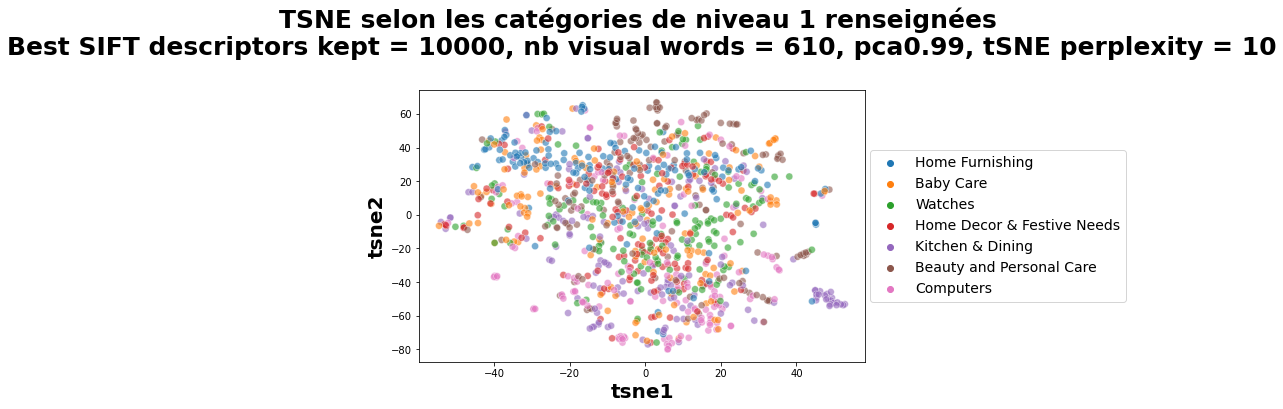

----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation of clustering


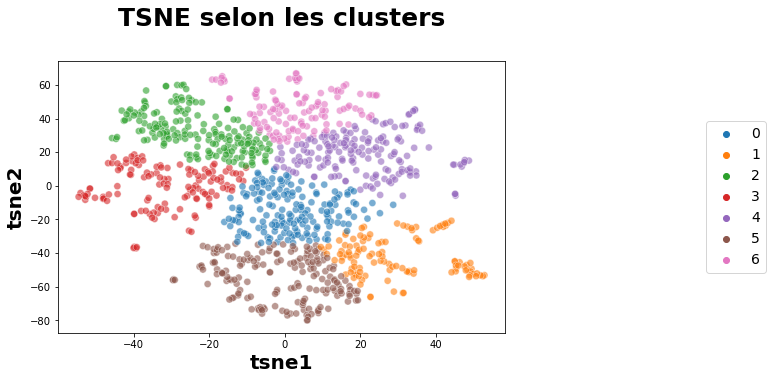

----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Optimized hyperparameters:
nb_SIFT_descriptors = 10000
nb visual words = 610
pca_var_expl = 0.99
perplexity = 10
ARI = 0.07575367222917541
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
total duration:           379.39 secondes


In [72]:
## Run méthode fournissant le meilleur ARI

temps0 = time.time()

# identification of key points and associated descriptors (SIFT)
nb_SIFT_descriptors = 10000
print('-' * 100)
print('##### Creation of ##{}## SIFT descriptors ...'.format(nb_SIFT_descriptors))
temps1 = time.time() # to get process duration
sift_keypoints = []
sift = cv2.SIFT_create(nb_SIFT_descriptors) # param 10000 = number of best features to retain
for image_num in range(len(data.image)) :
    if image_num%150 == 0 : print(image_num, ' / ', len(data.image)) # to track process progression
    # pretreatment of images:
    image = imread(path + data.image.tolist()[image_num]) # load image
    image = cv2.resize(image, (1000,1000), interpolation = cv2.INTER_LINEAR) # resize it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grey
    image = cv2.equalizeHist(image)   # equalize its histogram
    image = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) # filter noise
    res = cv2.medianBlur(image, 5) # filter salt and pepper noise
    # creation of SIFT descriptors
    kp, des = sift.detectAndCompute(res, None) # creation of couples (keypoint, descriptor)
    # addition of each descriptor (as np.array --1 np.array / descriptor per image) to the sift_keypoints list
    sift_keypoints.append(des) 
# transform into np.array the 'sift_keypoints' list of np.arrays
sift_keypoints_by_img = np.asarray(sift_keypoints)
# concatenate into a single np.array the descriptors of all images
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0) 
#
print("Nombre de descripteurs : ", sift_keypoints_all.shape)
duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

# Creation of visual words
kmax = int(round(np.sqrt(len(sift_keypoints_all)),0))
kmin = 70
kmean = int((round(np.sqrt(len(sift_keypoints_all)),0)+70)/2)
k = kmean
print('-' * 100)
print("##### Creation of ##{}## clusters of descriptors / visual words ...".format(k))
temps2 = time.time() # to get process duration
# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)
#
duration2 = time.time() - temps2
print("temps de traitement kmeans : ", "%15.2f" % duration2, "secondes")

# Creation of histograms / bags of visual words
print('-' * 100)    
print("##### Creation of bags of visual words ...")
temps3 = time.time() # to get process duration
hist_vectors=[] #histogram is the feature vector
for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%150 == 0 : print(i, ' / ', len(data.image))  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) # ajout de chaque vecteur (bag-of-visual-words) à la liste
im_features = np.asarray(hist_vectors) # conversion en np.array
#
duration3=time.time()-temps3
print("temps de création histogrammes : ", "%15.2f" % duration3, "secondes")      

# PCA        
pca_var_expl = 0.99
print('-' * 100)  
print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
temps4 = time.time() # to get PCA duration
# PCA
pca = decomposition.PCA(n_components=pca_var_expl)
feat_pca = pca.fit_transform(im_features)
#
duration4 = time.time() - temps4
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")

# t-SNE -- visual evaluation not done here
perplexity = 10
print('-' * 100)
print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
temps5 = time.time() # to get t-SNE duration
# Réduction dimensionnelle t-SNE
tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                     n_iter=5000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
# Création DF de dimension réduite avec label categ1
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["categ1"] = data.categ1
df_tsne["categ1_encoded"] = data.categ1_encoded
#
duration5 = time.time() - temps5
print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
# Visual evaluation
print('-' * 100)
print('##### Visual evaluation through t-SNE plot')
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="categ1", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
plt.title('TSNE selon les catégories de niveau 1 renseignées \n\
Best SIFT descriptors kept = {}, nb visual words = {}, pca{}, tSNE perplexity = {}'\
          .format(nb_SIFT_descriptors, k, pca_var_expl, perplexity),
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5)) 
plt.show()

# clustering -- visual evaluation not done here
print('-' * 100)
print('##### Clustering from 2D t-SNE ...')
temps6 = time.time() # to get clustering duration
# Clustering
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
#
duration6 = time.time() - temps6
print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
# Visual evaluation
print('-' * 100)
print('##### Visual evaluation of clustering')
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")
plt.title('TSNE selon les clusters',
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

# Calcul ARI
print('-' * 100)
print('##### ARI calculation ...')
temps7 = time.time() # to get ARI calculation duration
labels = data.categ1_encoded
ARI = metrics.adjusted_rand_score(labels, cls.labels_)
#
duration7 = time.time() - temps7
print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Check
print('-' * 100)
print('-' * 100)
print("Optimized hyperparameters:")
print('nb_SIFT_descriptors =', nb_SIFT_descriptors)
print('nb visual words =', k)
print('pca_var_expl =', pca_var_expl)
print('perplexity =', perplexity)
print('ARI =', ARI)

# total duration
print('-' * 100)
print('-' * 100)
duration8 = time.time() - temps0
print('total duration: ', "%15.2f" % duration8, "secondes")

### tests: visualisations TSNE puis PCA 3D (pas d'optimisation d'hyperparam, hyperparam fixés sur des valeurs arbitraires, première version de pré-traitements testée précédemment)

**> NON MONTRE ICI pour réduire la taille du notebook**

### Bilan
* 2 x 432 combinaisons d'hyperparm testées
* Clustering basé sur descripteurs SIFT franchement pas performant (meilleur ARI ~ 0.08)
* On pourrait faire des tests plus poussés sur les meilleurs pré-traitements d'images, mais vu les performances actuelles, je doute que cela permette de gagner significativement en performance

# Traitement des IMAGES des produits avec extraction features via VGG-16 - Transfer Learning
## Test Model version 1
### Creation du modèle

In [84]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
vgg16base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
print(vgg16base.summary())
print('-' * 100)
print('-' * 100)

# Ajout couche pour conversion matrice 3D issue de la base de vgg16 en vecteur 1D
model = Sequential()
model.add(vgg16base)
model.add(Flatten())

print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Extraction des features via VGG16-Transfer Learning sur nos images

In [85]:
vgg16TL_img_features = []

temps0 = time.time()

for image_num in range(len(data.image)):
    if image_num%150 == 0 : print(image_num, ' / ', len(data.image)) # to track process progression
        
    # pretreatment of images:
    image = load_img(path + data.image.tolist()[image_num], target_size=(224,224)) # load image with required size
    image = img_to_array(image) # convert it to np.array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # reshape as collection
    image = preprocess_input(image) # preprocess image as required for VGG16

    # get the extracted features
    vgg16TL_img_features.append(model.predict(image).reshape(-1))

duration = time.time() - temps0
print("temps d'extraction des features via VGG16 : ", "%15.2f" % duration, "secondes")

0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050
temps d'extraction des features via VGG16 :           212.87 secondes


In [86]:
# conversion list features en np.array
vgg16TL_img_features_ = np.asarray(vgg16TL_img_features)

### Visualisation rapide (sans optimisation) du résultat

----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)
temps de traitement PCA :             2.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation through t-SNE plot


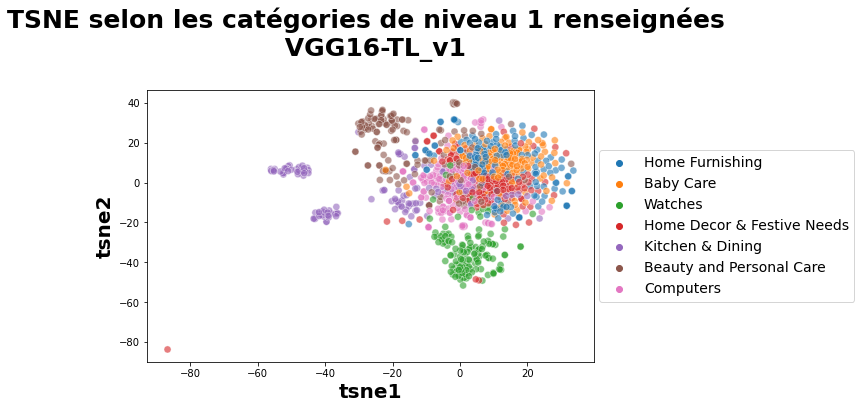

In [87]:
temps0 = time.time()

########### PCA ###########      
pca_var_expl = 0.99
print('-' * 100)  
print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
print("Dimensions dataset avant réduction PCA : ", vgg16TL_img_features_.shape)
temps4 = time.time() # to get PCA duration

# PCA
pca = decomposition.PCA(n_components=pca_var_expl)
vgg_feat_pca = pca.fit_transform(vgg16TL_img_features_)

#
duration4 = time.time() - temps4
print("Dimensions dataset après réduction PCA : ", vgg_feat_pca.shape)
print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")


########### t-SNE and visual evaluation ###########             

print('-' * 100)
print('##### t-SNE reduction ...')
temps5 = time.time() # to get t-SNE duration

# Réduction dimensionnelle t-SNE
tsne = manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(vgg_feat_pca)

# Création DF de dimension réduite avec label categ1
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["categ1"] = data.categ1
df_tsne["categ1_encoded"] = data.categ1_encoded
#
duration5 = time.time() - temps5
print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")

# Visual evaluation
print('-' * 100)
print('##### Visual evaluation through t-SNE plot')
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="categ1", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
plt.title('TSNE selon les catégories de niveau 1 renseignées \n VGG16-TL_v1',
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5)) 
plt.show()

**==> Cela semble beaucoup plus encourageant --> on va optimiser**
### Optimisation de pca_var_expl et perplexity via ARI

In [88]:
pca_expl_var_list = []
tsne_perplexity_list = []
ARI_list = []

# PCA        
for pca_var_expl in [0.8, 0.9, 0.99]:
    print('-' * 100)  
    print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
    print("Dimensions dataset avant réduction PCA : ", vgg16TL_img_features_.shape)
    temps4 = time.time() # to get PCA duration
    # PCA
    pca = decomposition.PCA(n_components=pca_var_expl)
    vgg_feat_pca = pca.fit_transform(vgg16TL_img_features_)
    #
    duration4 = time.time() - temps4
    print("Dimensions dataset après réduction PCA : ", vgg_feat_pca.shape)
    print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")

# t-SNE -- visual evaluation not done here
    for perplexity in [2,5,10,25,50,75,100,500,750]:
        print('-' * 100)
        print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
        temps5 = time.time() # to get t-SNE duration
    # Réduction dimensionnelle t-SNE
        tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                             n_iter=5000, init='random', random_state=1)
        X_tsne = tsne.fit_transform(vgg_feat_pca)
        # Création DF de dimension réduite avec label categ1
        df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
        df_tsne["categ1"] = data.categ1
        df_tsne["categ1_encoded"] = data.categ1_encoded
        #
        duration5 = time.time() - temps5
        print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
    # Visual evaluation removed here

# clustering -- visual evaluation not done here
        print('-' * 100)
        print('##### Clustering from 2D t-SNE ...')
        temps6 = time.time() # to get clustering duration
    # Clustering
        cls = cluster.KMeans(n_clusters=7, random_state=6)
        cls.fit(X_tsne)
        df_tsne["cluster"] = cls.labels_
        #
        duration6 = time.time() - temps6
        print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
    # Visual evaluation removed here

# Calcul ARI
        print('-' * 100)
        print('##### ARI calculation ...')
        temps7 = time.time() # to get ARI calculation duration
        labels = data.categ1_encoded
        ARI = metrics.adjusted_rand_score(labels, cls.labels_)
        #
        duration7 = time.time() - temps7
        print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Concatenation of hyperparameters and corresponding ARI results
        pca_expl_var_list.append(pca_var_expl)
        tsne_perplexity_list.append(perplexity)
        ARI_list.append(ARI)

# Creation of DF with results
results_dict_vgg = {'pca_expl_var': pca_expl_var_list,
                    'tsne_perplexity': tsne_perplexity_list,
                    'ARI': ARI_list}
results_vgg = pd.DataFrame(results_dict_vgg)

print('min ARI = ', min(results_vgg.ARI))
print('max ARI = ', max(results_vgg.ARI))
print('mean ARI = ', results_vgg.ARI.mean())
print('std_dev ARI = ', results_vgg.ARI.std())

display(HTML(results_vgg[results_vgg.ARI == max(results_vgg.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration9 = time.time() - temps4
print('total duration: ', "%15.2f" % duration9, "secondes")

----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 392)
temps de traitement PCA :             2.07 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
------------------------------------------------------------------------------------------

temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration:           186.51 secondes


## Test Model version 2 (ajout couche de pooling pour réduire encore plus la dimension)
### Creation du modèle

In [7]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
vgg16base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
print(vgg16base.summary())
print('-' * 100)
print('-' * 100)

# Ajout couche pour conversion matrice 3D issue de la base de vgg16 en vecteur 1D
model = Sequential()
model.add(vgg16base)
model.add(MaxPooling2D())
model.add(Flatten())

print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Extraction des features via VGG16-Transfer Learning sur nos images

In [8]:
vgg16TL_img_features = []

temps0 = time.time()

for image_num in range(len(data.image)):
    if image_num%150 == 0 : print(image_num, ' / ', len(data.image)) # to track process progression

    # pretreatment of images:
    image = load_img(path + data.image.tolist()[image_num], target_size=(224,224)) # load image with required size
    image = img_to_array(image) # convert it to np.array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # reshape as collection
    image = preprocess_input(image) # preprocess image as required for VGG16

    # get the extracted features
    vgg16TL_img_features.append(model.predict(image).reshape(-1))
        
duration = time.time() - temps0
print("temps d'extraction des features via VGG16 : ", "%15.2f" % duration, "secondes")

0  /  1050
150  /  1050
300  /  1050
450  /  1050
600  /  1050


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750  /  1050
900  /  1050
temps d'extraction des features via VGG16 :           199.90 secondes


In [9]:
# conversion list featutres en np.array
vgg16TL_img_features_ = np.asarray(vgg16TL_img_features)

### Optimisation de pca_var_expl et perplexity via ARI

In [92]:
pca_expl_var_list = []
tsne_perplexity_list = []
ARI_list = []

temps0 = time.time()

# PCA        
for pca_var_expl in [0.8, 0.9, 0.99]:
    print('-' * 100)  
    print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
    print("Dimensions dataset avant réduction PCA : ", vgg16TL_img_features_.shape)
    temps4 = time.time() # to get PCA duration
    # PCA
    pca = decomposition.PCA(n_components=pca_var_expl)
    vgg_feat_pca = pca.fit_transform(vgg16TL_img_features_)
    #
    duration4 = time.time() - temps4
    print("Dimensions dataset après réduction PCA : ", vgg_feat_pca.shape)
    print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")

# t-SNE -- visual evaluation not done here
    for perplexity in [2,5,10,25,50,75,100,500,750]:
        print('-' * 100)
        print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
        temps5 = time.time() # to get t-SNE duration
    # Réduction dimensionnelle t-SNE
        tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                             n_iter=5000, init='random', random_state=1)
        X_tsne = tsne.fit_transform(vgg_feat_pca)
        # Création DF de dimension réduite avec label categ1
        df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
        df_tsne["categ1"] = data.categ1
        df_tsne["categ1_encoded"] = data.categ1_encoded
        #
        duration5 = time.time() - temps5
        print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
    # Visual evaluation removed here

# clustering -- visual evaluation not done here
        print('-' * 100)
        print('##### Clustering from 2D t-SNE ...')
        temps6 = time.time() # to get clustering duration
    # Clustering
        cls = cluster.KMeans(n_clusters=7, random_state=6)
        cls.fit(X_tsne)
        df_tsne["cluster"] = cls.labels_
        #
        duration6 = time.time() - temps6
        print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
    # Visual evaluation removed here

# Calcul ARI
        print('-' * 100)
        print('##### ARI calculation ...')
        temps7 = time.time() # to get ARI calculation duration
        labels = data.categ1_encoded
        ARI = metrics.adjusted_rand_score(labels, cls.labels_)
        #
        duration7 = time.time() - temps7
        print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Concatenation of hyperparameters and corresponding ARI results
        pca_expl_var_list.append(pca_var_expl)
        tsne_perplexity_list.append(perplexity)
        ARI_list.append(ARI)

# Creation of DF with results
results_dict_vgg = {'pca_expl_var': pca_expl_var_list,
                    'tsne_perplexity': tsne_perplexity_list,
                    'ARI': ARI_list}
results_vgg = pd.DataFrame(results_dict_vgg)

print('min ARI = ', min(results_vgg.ARI))
print('max ARI = ', max(results_vgg.ARI))
print('mean ARI = ', results_vgg.ARI.mean())
print('std_dev ARI = ', results_vgg.ARI.std())

display(HTML(results_vgg[results_vgg.ARI == max(results_vgg.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration9 = time.time() - temps0
print('total duration: ', "%15.2f" % duration9, "secondes")

----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4608)
Dimensions dataset après réduction PCA :  (1050, 288)
temps de traitement PCA :             1.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
-------------------------------------------------------------------------------------------

temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.30 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.32 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :      

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration:          1091.84 secondes


**Bilan:** min, mean et max ARI sont tous meilleurs avec cette 2ème version de modèle

### affinage optimisation tsne_perplexity

In [93]:
temps0 = time.time()

# PCA
pca_var_expl = 0.99 #set to best value according to previous optimization
print('-' * 100)  
print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
print("Dimensions dataset avant réduction PCA : ", vgg16TL_img_features_.shape)
temps4 = time.time() # to get PCA duration
# PCA
pca = decomposition.PCA(n_components=pca_var_expl)
vgg_feat_pca = pca.fit_transform(vgg16TL_img_features_)
#
duration4 = time.time() - temps4
print("Dimensions dataset après réduction PCA : ", vgg_feat_pca.shape)
print("temps de traitement PCA : ", "%15.2f" % duration4, "secondes")

# t-SNE -- visual evaluation not done here
for perplexity in [15,20,30,35,40,45]:
    print('-' * 100)
    print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
    temps5 = time.time() # to get t-SNE duration
# Réduction dimensionnelle t-SNE
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                         n_iter=5000, init='random', random_state=1)
    X_tsne = tsne.fit_transform(vgg_feat_pca)
    # Création DF de dimension réduite avec label categ1
    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["categ1"] = data.categ1
    df_tsne["categ1_encoded"] = data.categ1_encoded
    #
    duration5 = time.time() - temps5
    print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
# Visual evaluation removed here

# clustering -- visual evaluation not done here
    print('-' * 100)
    print('##### Clustering from 2D t-SNE ...')
    temps6 = time.time() # to get clustering duration
# Clustering
    cls = cluster.KMeans(n_clusters=7, random_state=6)
    cls.fit(X_tsne)
    df_tsne["cluster"] = cls.labels_
    #
    duration6 = time.time() - temps6
    print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
# Visual evaluation removed here

# Calcul ARI
    print('-' * 100)
    print('##### ARI calculation ...')
    temps7 = time.time() # to get ARI calculation duration
    labels = data.categ1_encoded
    ARI = metrics.adjusted_rand_score(labels, cls.labels_)
    #
    duration7 = time.time() - temps7
    print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Concatenation of hyperparameters and corresponding ARI results
    pca_expl_var_list.append(pca_var_expl)
    tsne_perplexity_list.append(perplexity)
    ARI_list.append(ARI)

# Creation of DF with results
results_dict_vgg = {'pca_expl_var': pca_expl_var_list,
                    'tsne_perplexity': tsne_perplexity_list,
                    'ARI': ARI_list}
results_vgg = pd.DataFrame(results_dict_vgg)

print('min ARI = ', min(results_vgg.ARI))
print('max ARI = ', max(results_vgg.ARI))
print('mean ARI = ', results_vgg.ARI.mean())
print('std_dev ARI = ', results_vgg.ARI.std())

display(HTML(results_vgg[results_vgg.ARI == max(results_vgg.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration9 = time.time() - temps0
print('total duration: ', "%15.2f" % duration9, "secondes")

----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4608)
Dimensions dataset après réduction PCA :  (1050, 883)
temps de traitement PCA :             2.95 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...
temps de traitement t-SNE :           269.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.25 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration:           245.86 secondes


### Essai t-SNE 3D (pca_var_expl = 0.99) - ARI moins bon qu'en 2D, donc NON MONTRE ICI pour alléger le notebook

## BILAN TRAITEMENT / CLUSTERING IMAGES
* extraction features via SIFT moins performante que extraction features via VGG16-Transfer Learning
* clustering optimisé:
    * Model = base VGG16 + couche de pooling (+ flatten)
    * 1ère réduction dimensionnelle PCA à 99% de variance expliquée
    * 2ème réduction dimensionnelle t-SNE 2D avec perplexity = 45
    * **==> ARI = 0.424437** --> ca. 42% des paires de produits correctement classifiées **sur la base seule des images**
* df features optimisées stockées dans:
    * **img_feat_pca99** = vgg_feat_pca.copy()
    * **img_feat_tsne2d45** = df_tsne.copy()
* optimisation plus poussée potentielle :
    * autre modèle CNN (+ Transfer Learning) avec images plus similaires ???
    * ajout couche de pooling pour réduire encore la dimension des vecteurs features en sortie du CNN ???
    * ajout d'un classifieur 7 classes (couche Dense, activation softmax) en fin de modèle et entrainement seulement du classifieur
    
### Run méthode optimisée

----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...
temps de traitement t-SNE :             4.92 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation through t-SNE plot


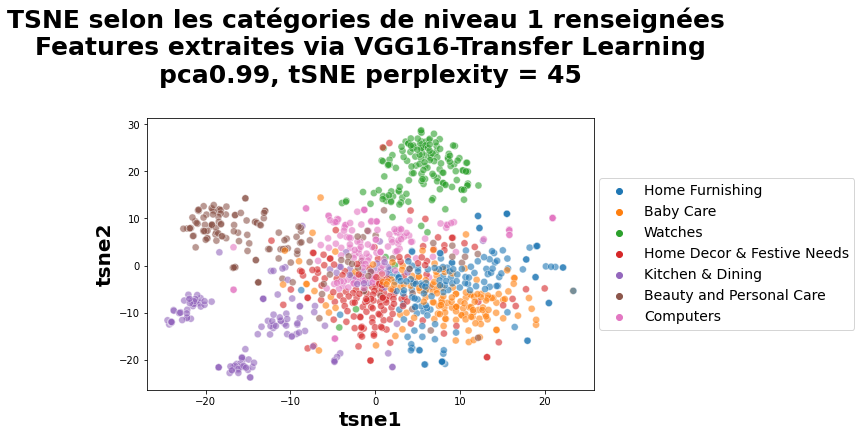

----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.53 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation of clustering


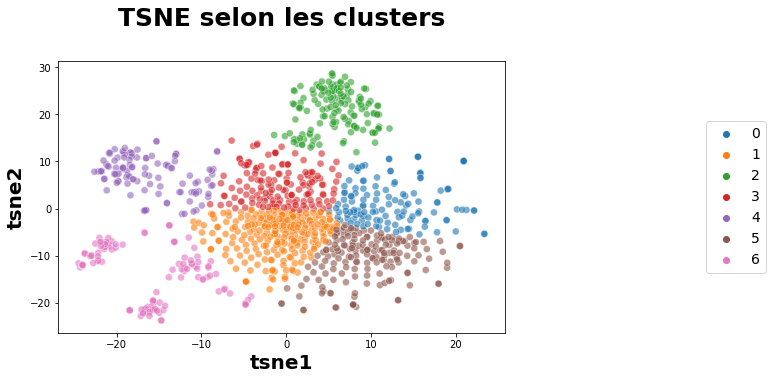

----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.05 secondes
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Optimized hyperparameters:
pca_var_expl = 0.99
perplexity = 45
ARI = 0.42443659109835674
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
total duration:            47.78 secondes


In [613]:
# VGG16 model version 2 features predictions already done and stored
# PCA already done and stored

# t-SNE and visual evaluation               
perplexity = 45
print('-' * 100)
print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
temps5 = time.time() # to get t-SNE duration
# Réduction dimensionnelle t-SNE
tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                     n_iter=5000, init='random', random_state=1)
X_tsne = tsne.fit_transform(vgg_feat_pca)
# Création DF de dimension réduite avec label categ1
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["categ1"] = data.categ1
df_tsne["categ1_encoded"] = data.categ1_encoded
#
duration5 = time.time() - temps5
print("temps de traitement t-SNE : ", "%15.2f" % duration1, "secondes")
# Visual evaluation
print('-' * 100)
print('##### Visual evaluation through t-SNE plot')
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="categ1", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
plt.title('TSNE selon les catégories de niveau 1 renseignées \n\
Features extraites via VGG16-Transfer Learning\n\
pca{}, tSNE perplexity = {}'\
          .format(pca_var_expl, perplexity),
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5)) 
plt.show()

# clustering and visual evaluation
print('-' * 100)
print('##### Clustering from 2D t-SNE ...')
temps6 = time.time() # to get clustering duration
# Clustering
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
#
duration6 = time.time() - temps6
print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration6, "secondes")
# Visual evaluation
print('-' * 100)
print('##### Visual evaluation of clustering')
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")
plt.title('TSNE selon les clusters',
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

# Calcul ARI
print('-' * 100)
print('##### ARI calculation ...')
temps7 = time.time() # to get ARI calculation duration
labels = data.categ1_encoded
ARI = metrics.adjusted_rand_score(labels, cls.labels_)
#
duration7 = time.time() - temps7
print("temps de calcul ARI : ", "%15.2f" % duration7, "secondes")

# Check
print('-' * 100)
print('-' * 100)
print("Optimized hyperparameters:")
print('pca_var_expl =', pca_var_expl)
print('perplexity =', perplexity)
print('ARI =', ARI)


print('-' * 100)
print('-' * 100)
duration9 = time.time() - temps5
print('total duration: ', "%15.2f" % duration9, "secondes")

In [232]:
# storage of feature df under more generic names for further use
img_feat_pca99 = pd.DataFrame(vgg_feat_pca)
img_feat_pca99 = img_feat_pca99.add_prefix('img_pca_feat_')
img_feat_pca99["categ1"] = data.categ1
img_feat_pca99['categ1_encoded'] = data.categ1_encoded
img_feat_pca99["uniq_id"] = data.uniq_id

img_feat_tsne2d45 = df_tsne.copy()
img_feat_tsne2d45["uniq_id"] = data.uniq_id

### Matrice de confusion et graphes de répartition

In [614]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 72  26   0   4   0  48   0]
 [ 16  27   0   8   1  97   1]
 [  0   3 138   9   0   0   0]
 [ 13  98   2  19   1  14   3]
 [  1  23   0   5   6   4 111]
 [  6  18   0  13 106   4   3]
 [ 22  31   0  92   3   0   2]]


In [615]:
# non alignée donc alignement à la main
def conf_mat_transform(y_true,y_pred):
    '''Fonction de mise en correspondance
    entre labels vrais et clusters prédits
    dans la matrice de confusion'''
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    corresp = np.argmax(conf_mat, axis=0) # pas de pb de correspondance categ vraie-cluster pred
    # corresp = [1, 2, 0, 3, 4, 5, 6] # correspondance manuelle lorsque pb
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 3 2 6 5 1 4]
[[ 72  48   0  26   0   0   4]
 [ 16  97   0  27   1   1   8]
 [  0   0 138   3   0   0   9]
 [ 13  14   2  98   3   1  19]
 [  1   4   0  23 111   6   5]
 [  6   4   0  18   3 106  13]
 [ 22   0   0  31   2   3  92]]

              precision    recall  f1-score   support

           0       0.55      0.48      0.51       150
           1       0.58      0.65      0.61       150
           2       0.99      0.92      0.95       150
           3       0.43      0.65      0.52       150
           4       0.93      0.74      0.82       150
           5       0.91      0.71      0.79       150
           6       0.61      0.61      0.61       150

    accuracy                           0.68      1050
   macro avg       0.71      0.68      0.69      1050
weighted avg       0.71      0.68      0.69      1050



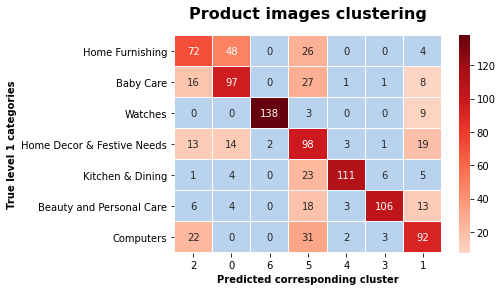

In [767]:
import copy

categ_list = []
for key, val in categ1_encoding.items():
    categ_list.append(key)

df_cm1 = pd.DataFrame(conf_mat, index = [categ for categ in categ_list],
                     columns = [i for i in "2065431"])
plt.figure(figsize = (6,4))
plt.title('Product images clustering', fontweight='bold', fontsize=16, y=1.05)
cmap = copy.copy(plt.get_cmap("Reds"))
cmap.set_under('#B9D3EE')
sns.heatmap(df_cm1, annot=True, fmt='.0f', cmap=cmap, lw=0.005, center=60, vmin=150*0.05)
plt.ylabel('True level 1 categories', fontweight='bold')
plt.xlabel('Predicted corresponding cluster', fontweight='bold')

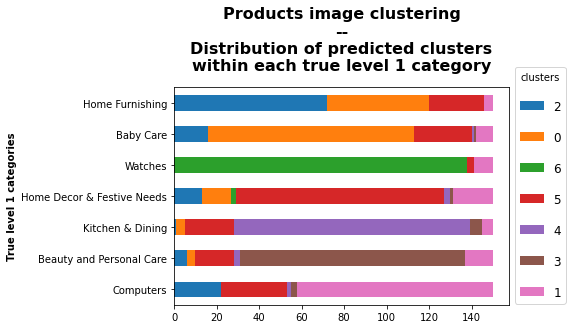

In [759]:
ax = df_cm1.plot.barh(stacked=True)
ax.set_title('Products image clustering\n--\nDistribution of predicted clusters\nwithin each true level 1 category',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_ylabel('True level 1 categories', fontweight='bold')
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.55),
          fontsize=12, labelspacing=1.5, title='clusters')

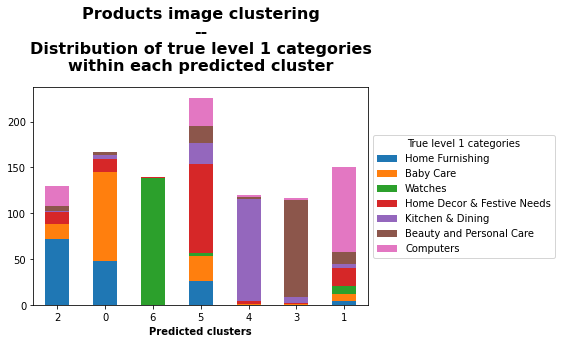

In [664]:
ax = df_cm1.T.plot.bar(stacked=True)
ax.set_title('Products image clustering\n--\nDistribution of true level 1 categories\nwithin each predicted cluster',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_xticklabels([i for i in "2065431"], rotation=0)
ax.set_xlabel('Predicted clusters', fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='True level 1 categories')

# Traitement des DESCRIPTIONS des produits
## Pré-traitement NLP
* tokenize, remove punctuation and numbers, put in lowercase
* remove English stopwords
* remove most frequent words
* lemmatisation

### tokenize, remove punctuation and numbers, put in lowercase

In [19]:
# tokenize, remove punctuation and numbers, put in lowercase, 
# and gather product descriptions as a list of each product description tokens
tokenized_desc_list = []

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+') # tokenizer that removes punctuation and numbers

for desc in data.description:
    tokenized_desc = tokenizer.tokenize(desc.lower()) # apply tokenizer + put text in lowercase
    tokenized_desc_list.append(tokenized_desc)

In [20]:
# Check length of tokenized descriptions
def check_length (list_, long):
    len_desc = []
    for desc in list_:
        len_desc.append(len(desc))
    print('nb of words in longest description =', max(len_desc))
    print('nb of words in shortest description =', min(len_desc))
    print('-' * 50)
    print('INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :\n', data.description[len_desc.index(min(len_desc))])
    print('-' * 50)
    print('CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :\n',list_[len_desc.index(min(len_desc))])
    if long == True:
        print('-' * 50)
        print('-' * 50)
        print('INITIAL STATE OF LONGEST MODIFIED DESCRIPTION :\n', data.description[len_desc.index(max(len_desc))])
        print('-' * 50)
        print('CURRENT STATE OF LONGEST MODIFIED DESCRIPTION :\n',list_[len_desc.index(max(len_desc))])
    
check_length(tokenized_desc_list, long=False)

nb of words in longest description = 572
nb of words in shortest description = 13
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Next Steps Baby Girl's Layered Dress
                         Price: Rs. 356
				
			Girls Dress
Girls Dress
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['next', 'steps', 'baby', 'girl', 's', 'layered', 'dress', 'price', 'rs', 'girls', 'dress', 'girls', 'dress']


### remove English stopwords

In [21]:
# Remove English stopwords
nltk.download('stopwords')
english_stopwords=nltk.corpus.stopwords.words("english")

print(english_stopwords)
print('-' * 100)

modif1_desc_list = []
for desc in tokenized_desc_list:
    modif1_desc_list.append([word for word in desc if not word in english_stopwords])
    
# Check length of modified descriptions
check_length(modif1_desc_list, long=False)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# English stopwords version 2 (source = https://gist.github.com/sebleier/554280)
en_stopwords = set(["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"])

# Remove English stopwords version 2
modif1_desc_list = []
for desc in tokenized_desc_list:
    modif1_desc_list.append([word for word in desc if not word in en_stopwords])
    
# Check length of modified descriptions
check_length(modif1_desc_list, long=False)

nb of words in longest description = 325
nb of words in shortest description = 11
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Next Steps Baby Girl's Layered Dress
                         Price: Rs. 356
				
			Girls Dress
Girls Dress
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['steps', 'baby', 'girl', 'layered', 'dress', 'price', 'rs', 'girls', 'dress', 'girls', 'dress']


### Remove most frequent words

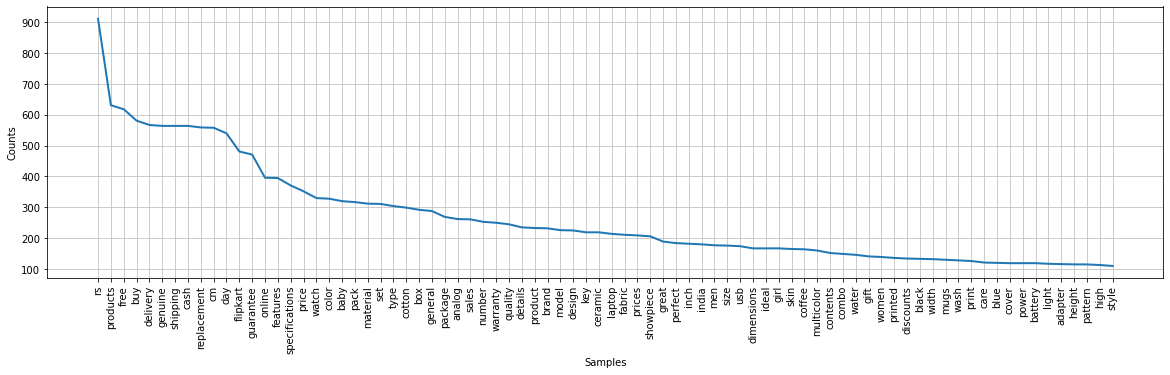

In [23]:
# Determine most frequent words
flat_list = [item for sublist in modif1_desc_list for item in sublist]

fd = nltk.FreqDist(flat_list)
plt.figure(figsize=(20, 5))
fd.plot(80)

In [24]:
# Restriction to the 17 most frequent words (to keep 'watch' as the most frequent word not to remove
# from description in case it's not a verb but the actual name of products)
most_freq = []
nb_most_freq = 17
for i in range (0,nb_most_freq,1):
    most_freq.append(fd.most_common(nb_most_freq)[i][0])

# addition of some others most freq words
for w in ['prices', 'inch', 'size', 'dimensions', 'discounts', 'ideal', 'width']:
    most_freq.append(w)
most_freq

['rs',
 'products',
 'free',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'cm',
 'day',
 'flipkart',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price',
 'prices',
 'inch',
 'size',
 'dimensions',
 'discounts',
 'ideal',
 'width']

In [25]:
# set the 1st 18 most frequent words as stopwords and remove them
most_freq_stopwords = set()
most_freq_stopwords.update(most_freq)

modif2_desc_list = []
for desc in modif1_desc_list:
    modif2_desc_list.append([word for word in desc if not word in most_freq_stopwords])

print('Verification -- nb of descriptions = {} / 1050'.format(len(modif2_desc_list)))
print('-' * 100)

# check length of modified descriptions:
check_length(modif2_desc_list, long=True)

Verification -- nb of descriptions = 1050 / 1050
----------------------------------------------------------------------------------------------------
nb of words in longest description = 301
nb of words in shortest description = 1
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Buy Intex W150D only for Rs. 1149 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['intex']
--------------------------------------------------
--------------------------------------------------
INITIAL STATE OF LONGEST MODIFIED DESCRIPTION :
 Key Features of HomeEdge Solid Wood King Bed King Bed 72x78 Mattress Size 1 King Bed Natural Polish,HomeEdge Solid Wood King Bed (Finish Color -  Natural) Price: Rs. 18,799 Made to Order SolidWood Bed made by the finest artisans from Rajasthan. Bed is made to perfect

### Lemmatisation vs racinisation + new most frequent words
#### Lemmatisation

In [26]:
# lemmatization
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_desc_list = []

for desc in modif2_desc_list:
    lemmatized_desc_list.append([lemmatizer.lemmatize(word) for word in desc])
    
# check length of modified descriptions:
check_length(lemmatized_desc_list, long=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


nb of words in longest description = 301
nb of words in shortest description = 1
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Buy Intex W150D only for Rs. 1149 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['intex']
--------------------------------------------------
--------------------------------------------------
INITIAL STATE OF LONGEST MODIFIED DESCRIPTION :
 Key Features of HomeEdge Solid Wood King Bed King Bed 72x78 Mattress Size 1 King Bed Natural Polish,HomeEdge Solid Wood King Bed (Finish Color -  Natural) Price: Rs. 18,799 Made to Order SolidWood Bed made by the finest artisans from Rajasthan. Bed is made to perfection. These Beds are handicraft products which are made to order by the manufacturer. Please make sure that this bed is ordered once you are aware of t

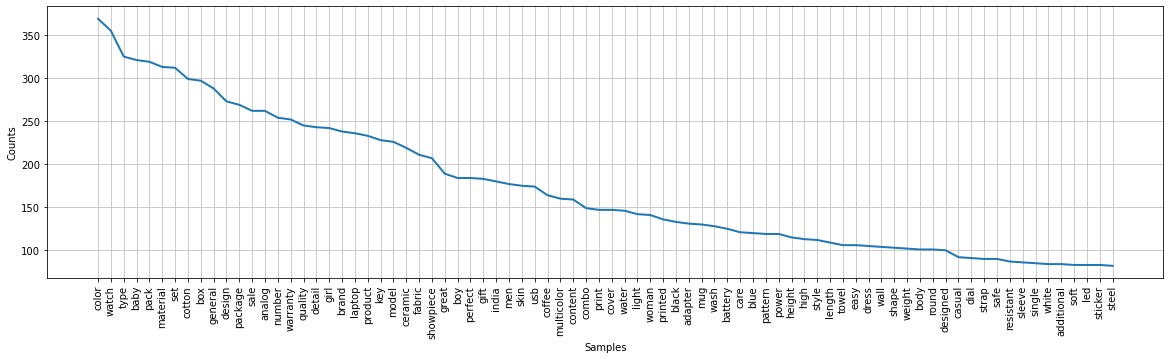

In [27]:
# Determine new most frequent words
flat_list = [item for sublist in lemmatized_desc_list for item in sublist]

fd = nltk.FreqDist(flat_list)
plt.figure(figsize=(20, 5))
fd.plot(80)

#### Racinisation avec SnowballStemmer

In [28]:
# Racinisation (stemming)
stemmer = nltk.stem.SnowballStemmer("english")
stemmed_desc_list = []

for desc in modif2_desc_list:
    stemmed_desc_list.append([stemmer.stem(word) for word in desc])
    
# check length of modified descriptions:
check_length(stemmed_desc_list, long=True)

nb of words in longest description = 301
nb of words in shortest description = 1
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Buy Intex W150D only for Rs. 1149 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['intex']
--------------------------------------------------
--------------------------------------------------
INITIAL STATE OF LONGEST MODIFIED DESCRIPTION :
 Key Features of HomeEdge Solid Wood King Bed King Bed 72x78 Mattress Size 1 King Bed Natural Polish,HomeEdge Solid Wood King Bed (Finish Color -  Natural) Price: Rs. 18,799 Made to Order SolidWood Bed made by the finest artisans from Rajasthan. Bed is made to perfection. These Beds are handicraft products which are made to order by the manufacturer. Please make sure that this bed is ordered once you are aware of t

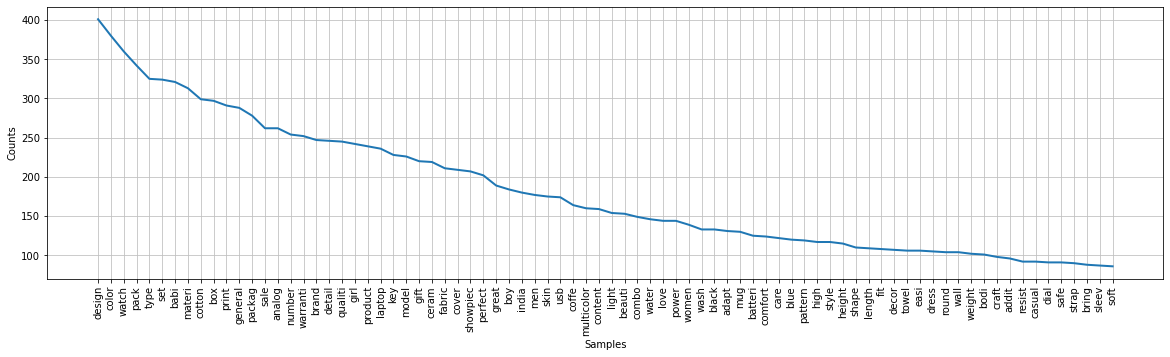

In [29]:
# Determine new most frequent words
flat_list = [item for sublist in stemmed_desc_list for item in sublist]

fd = nltk.FreqDist(flat_list)
plt.figure(figsize=(20, 5))
fd.plot(80)

#### Racinisation avec LancasterStemmer

In [30]:
# Racinisation 2 (stemming)
stemmer2 = nltk.stem.LancasterStemmer()
stemmed2_desc_list = []

for desc in modif2_desc_list:
    stemmed2_desc_list.append([stemmer2.stem(word) for word in desc])
    
# check length of modified descriptions:
check_length(stemmed2_desc_list, long=True)

nb of words in longest description = 301
nb of words in shortest description = 1
--------------------------------------------------
INITIAL STATE OF SHORTEST MODIFIED DESCRIPTION :
 Buy Intex W150D only for Rs. 1149 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
--------------------------------------------------
CURRENT STATE OF SHORTEST MODIFIED DESCRIPTION :
 ['intex']
--------------------------------------------------
--------------------------------------------------
INITIAL STATE OF LONGEST MODIFIED DESCRIPTION :
 Key Features of HomeEdge Solid Wood King Bed King Bed 72x78 Mattress Size 1 King Bed Natural Polish,HomeEdge Solid Wood King Bed (Finish Color -  Natural) Price: Rs. 18,799 Made to Order SolidWood Bed made by the finest artisans from Rajasthan. Bed is made to perfection. These Beds are handicraft products which are made to order by the manufacturer. Please make sure that this bed is ordered once you are aware of t

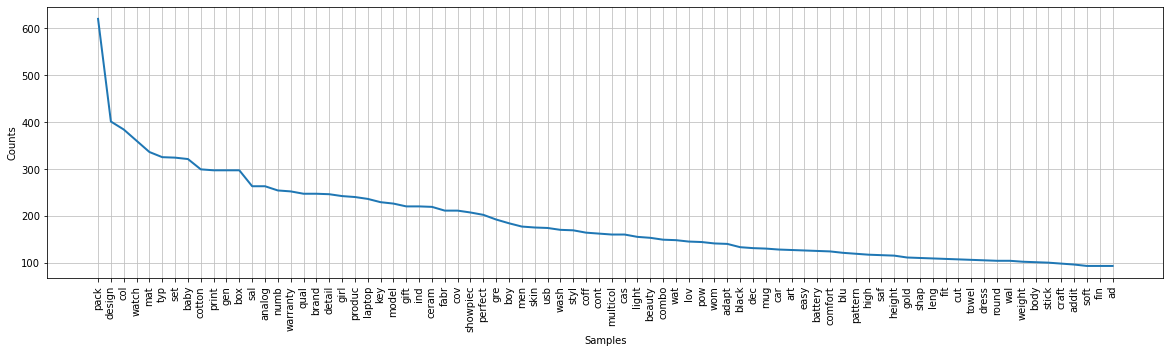

In [31]:
# Determine new most frequent words
flat_list = [item for sublist in stemmed2_desc_list for item in sublist]

fd = nltk.FreqDist(flat_list)
plt.figure(figsize=(20, 5))
fd.plot(80)

==> On va utiliser les lemmes -- **lemmatized_desc_list** (car Lancaster trop agressif // a priori pas grande différence entre SnowballStemmer et WordNetLemmatizer mais les lemmes sont plus compréhensibles - au cas où on aurait besoin de revenir dessus), et ne pas ajouter de nouveaux stopwords pour l'instant.

## Extraction de features
### Bag-of-words

In [36]:
count_vectorizer = CountVectorizer()

lemmatized_desc_list_vect = [" ".join(x) for x in lemmatized_desc_list]

bag_of_words = count_vectorizer.fit_transform(lemmatized_desc_list_vect).toarray()

df_BoW = pd.DataFrame(bag_of_words,
                      columns = count_vectorizer.get_feature_names())
df_BoW.insert(0, "uniq_id", data.uniq_id)
df_BoW['categ1'] = data.categ1
df_BoW['categ1_encoded'] = data.categ1_encoded

In [37]:
df_BoW.head(2)

uniq_id  aa  aaa  aapno  aari  aarika  ability  \
0  55b85ea15a1536d46b7190ad6fff8ce7   0    0      0     0       0        0   
1  7b72c92c2f6c40268628ec5f14c6d590   0    0      0     0       0        0   

   abkl  abode  abrasion  ...  zip  zipexterior  zipper  zippered  zone  zoom  \
0     0      0         0  ...    0            0       0         0     0     0   
1     0      0         0  ...    0            0       0         0     0     0   

   zora  zyxel           categ1  categ1_encoded  
0     0      0  Home Furnishing               0  
1     0      0        Baby Care               1  

[2 rows x 4433 columns]

### Bag-of-words tf-idf

In [38]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(lemmatized_desc_list_vect).toarray()

df_tfidf = pd.DataFrame(X,
                        columns = vectorizer.get_feature_names())
df_tfidf.insert(0, "uniq_id", data.uniq_id)
df_tfidf['categ1'] = data.categ1
df_tfidf['categ1_encoded'] = data.categ1_encoded

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
df_tfidf.head(2)

uniq_id   aa  aaa  aapno  aari  aarika  ability  \
0  55b85ea15a1536d46b7190ad6fff8ce7  0.0  0.0    0.0   0.0     0.0      0.0   
1  7b72c92c2f6c40268628ec5f14c6d590  0.0  0.0    0.0   0.0     0.0      0.0   

   abkl  abode  abrasion  ...  zip  zipexterior  zipper  zippered  zone  zoom  \
0   0.0    0.0       0.0  ...  0.0          0.0     0.0       0.0   0.0   0.0   
1   0.0    0.0       0.0  ...  0.0          0.0     0.0       0.0   0.0   0.0   

   zora  zyxel           categ1  categ1_encoded  
0   0.0    0.0  Home Furnishing               0  
1   0.0    0.0        Baby Care               1  

[2 rows x 4433 columns]

### Bag-of-bigrams tf-idf

In [40]:
vectorizer2 = TfidfVectorizer(ngram_range = (2,2))

X2 = vectorizer2.fit_transform(lemmatized_desc_list_vect).toarray()

df_tfidf_bigrams = pd.DataFrame(X2,
                                columns = vectorizer2.get_feature_names())
df_tfidf_bigrams.insert(0, "uniq_id", data.uniq_id)
df_tfidf_bigrams['categ1'] = data.categ1
df_tfidf_bigrams['categ1_encoded'] = data.categ1_encoded

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
df_tfidf_bigrams.head(2)

uniq_id  aa battery  aa pencil  aaa battery  \
0  55b85ea15a1536d46b7190ad6fff8ce7         0.0        0.0          0.0   
1  7b72c92c2f6c40268628ec5f14c6d590         0.0        0.0          0.0   

   aapno rajasthan  aari embroidered  aari embroidery  aarika design  \
0              0.0               0.0              0.0            0.0   
1              0.0               0.0              0.0            0.0   

   ability aid  ability lightweight  ...  zone pillow  zone printed  zone uv  \
0          0.0                  0.0  ...          0.0           0.0      0.0   
1          0.0                  0.0  ...          0.0           0.0      0.0   

   zoom type  zora laptop  zyxel data  zyxel pla  zyxel vmg           categ1  \
0        0.0          0.0         0.0        0.0        0.0  Home Furnishing   
1        0.0          0.0         0.0        0.0        0.0        Baby Care   

   categ1_encoded  
0               0  
1               1  

[2 rows x 16006 columns]

Si on utilise non pas les lemmes mais:
* les racines via SnowballStemmer : df_tfidf_bigrams shape = (1050, 15837)
* les racines via LancasterStemmer: df_tfidf_bigrams shape = (1050,15739)

### word embedding avec Word2Vec

Word2Vec Training parameters:
* __min_count__ for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them: ``default value of min_count=5``
* __vector_size__ is the number of dimensions (N) of the N-dimensional space that gensim Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds. ``default value of vector_size=100``
* __workers__, the last of the major parameters, is for training parallelization, to speed up training. ``default value of workers=3 (tutorial says 1...)`` The workers parameter only has an effect if you have Cython installed. Without Cython, you’ll only be able to use one core because of the GIL (and word2vec training will be miserably slow).

In [43]:
# train model (with default parameters here)
model = Word2Vec(lemmatized_desc_list)

In [44]:
# nombre de mots considérés sur les 4433 dispo:
len(model.wv.index_to_key)

1361

In [45]:
# Vérif rapide de la cohérence du word embedding
modified_categ_list = []

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+') # tokenizer that removes punctuation and numbers

for categ in data.categ1.unique().tolist():
    tokenized_categ = tokenizer.tokenize(categ.lower()) # apply tokenizer + put text in lowercase
    for tokenized_categ_unique in tokenized_categ:
        modified_categ_list.append(lemmatizer.lemmatize(tokenized_categ_unique))

for categ in modified_categ_list:
    print('-' * 40)
    print(categ)    
    if categ in model.wv.index_to_key:
        print('-' * 20)
        print(model.wv.most_similar(positive=[categ]))
        print('-' * 40)
    else:
        print('-' * 20)
        print('tokenized-lemmatized_categ not present')
        print('-' * 40)        

----------------------------------------
home
--------------------
tokenized-lemmatized_categ not present
----------------------------------------
----------------------------------------
furnishing
--------------------
[('decorative', 0.9947969913482666), ('stone', 0.994659960269928), ('duvet', 0.9946547746658325), ('showpiece', 0.9945831298828125), ('grade', 0.9945388436317444), ('accessory', 0.9945242404937744), ('wooden', 0.9945233464241028), ('item', 0.9944999814033508), ('crafted', 0.9944920539855957), ('beautiful', 0.9944738745689392)]
----------------------------------------
----------------------------------------
baby
--------------------
[('occasion', 0.9976620078086853), ('dress', 0.997237503528595), ('girl', 0.9959664940834045), ('shirt', 0.9952539801597595), ('neck', 0.9944522380828857), ('gathered', 0.9942548274993896), ('pattern', 0.9938015341758728), ('romper', 0.990885317325592), ('striped', 0.9904652237892151), ('bodysuit', 0.9899455308914185)]
----------------------

Il y a qq bizarreries mais dans l'ensemble ça semble assez cohérent

In [46]:
# Création du df
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(corpus, model):
    feats = np.vstack([sum_vectors(p, model) for p in corpus])
    return feats

df_Word2Vec = pd.DataFrame(word2vec_features(lemmatized_desc_list, model))
print(df_Word2Vec.shape)
df_Word2Vec = df_Word2Vec.add_prefix('Word2Vec_')
df_Word2Vec.insert(0, "uniq_id", data.uniq_id)
df_Word2Vec['categ1'] = data.categ1
df_Word2Vec['categ1_encoded'] = data.categ1_encoded

(1050, 100)


In [47]:
df_Word2Vec.head(2)

uniq_id  Word2Vec_0  Word2Vec_1  Word2Vec_2  \
0  55b85ea15a1536d46b7190ad6fff8ce7  -23.939072   24.274318   -2.608881   
1  7b72c92c2f6c40268628ec5f14c6d590  -11.913848   12.739748   -2.009857   

   Word2Vec_3  Word2Vec_4  Word2Vec_5  Word2Vec_6  Word2Vec_7  Word2Vec_8  \
0  -12.139570     9.06577  -39.972904   11.005123   43.595668  -11.958985   
1   -5.934192     5.80646  -21.005025    6.752694   23.698059   -5.755529   

   ...  Word2Vec_92  Word2Vec_93  Word2Vec_94  Word2Vec_95  Word2Vec_96  \
0  ...     7.045206   -22.664055    44.397992    20.445360     4.565384   
1  ...     3.618532   -12.488904    24.068336     9.387384     1.911812   

   Word2Vec_97  Word2Vec_98  Word2Vec_99           categ1  categ1_encoded  
0   -38.613334    21.714921    -1.145105  Home Furnishing               0  
1   -19.173962    10.719662    -0.454413        Baby Care               1  

[2 rows x 103 columns]

## Optimisation extraction de features et réductions dimensionelles pré-clustering
* PCA sur BoW et tf-idf /// nb vecteurs de Word2Vec
* t-SNE

==> mesure performances via ARI du clustering effectué sur données réduites après t-SNE

In [48]:
# hyperparam controlling the number of features considered before t-SNE:
nb_vectors_list = [] # nb vectors of Word2Vec
pca_expl_var_list = []
    # just to keep track
method_list = []
nb_reduced_dim_list = []

# other hyperparams optimized:
tsne_perplexity_list = []
tsne_init_list = []
ARI_list = []


############# Optimization 1 ##############
temps0 = time.time()

for method in ['BoW', 'tfidf', 'Word2Vec']:
    print('-' * 100)
    print("##### Run of method ##{}## ...".format(method))
    if method == 'BoW' or method == 'tfidf':
        nb_vectors = np.nan # aurait pu être nb colonnes du dataset après PCA
        if method == 'BoW':
            input_data = df_BoW.iloc[:,1:4431]
        if method == 'tfidf':
            input_data = df_tfidf.iloc[:,1:4431]
        # run PCA in both cases      
        for pca_var_expl in [0.8, 0.9, 0.99]:
            print('-' * 100)  
            print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
            print("Dimensions dataset avant réduction PCA : ", input_data.shape)
            temps1 = time.time() # to get PCA duration
            ### PCA
            pca = decomposition.PCA(n_components=pca_var_expl)
            feat_data = pca.fit_transform(input_data)
            #
            duration1 = time.time() - temps1
            print("Dimensions dataset après réduction PCA : ", feat_data.shape)
            print("temps de traitement PCA : ", "%15.2f" % duration1, "secondes")
            
            nb_reduced_dim = feat_data.shape[1]

    # t-SNE and visual evaluation               
            for perplexity in [2,5,10,15,20,25,30,35,40,45,50,75,100,500]:
                print('-' * 100)
                print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
                temps3 = time.time() # to get t-SNE duration
            # Réduction dimensionnelle t-SNE
                init_met = 'random'
                tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                     n_iter=5000, init=init_met, random_state=6)
                X_tsne = tsne.fit_transform(feat_data)
                # Création DF de dimension réduite avec label categ1
                df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                df_tsne["categ1"] = data.categ1
                df_tsne["categ1_encoded"] = data.categ1_encoded
                #
                duration3 = time.time() - temps3
                print("temps de traitement t-SNE : ", "%15.2f" % duration3, "secondes")
            # Visual evaluation removed here

    # clustering and visual evaluation
                print('-' * 100)
                print('##### Clustering from 2D t-SNE ...')
                temps4 = time.time() # to get clustering duration
            # Clustering
                cls = cluster.KMeans(n_clusters=7, random_state=1)
                cls.fit(X_tsne)
                df_tsne["cluster"] = cls.labels_
                #
                duration4 = time.time() - temps4
                print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration4, "secondes")
            # Visual evaluation removed here

    # Calcul ARI
                print('-' * 100)
                print('##### ARI calculation ...')
                temps5 = time.time() # to get ARI calculation duration
                labels = data.categ1_encoded
                ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                #
                duration5 = time.time() - temps5
                print("temps de calcul ARI : ", "%15.2f" % duration5, "secondes")

    # Concatenation of hyperparameters and corresponding ARI results
                pca_expl_var_list.append(pca_var_expl)
                nb_vectors_list.append(nb_vectors)
                nb_reduced_dim_list.append(nb_reduced_dim)
                tsne_perplexity_list.append(perplexity)
                tsne_init_list.append(init_met)
                ARI_list.append(ARI)
                method_list.append(method)

    # process duration of each complete loop 
                duration6 = time.time() - temps1
                print('Temps de traitement de chaque boucle complète : ',
                  "%15.2f" % duration6, "secondes")                 
            
    if method == 'Word2Vec':
        pca_var_expl = np.nan
        for nb_vectors in [50,100,200,300,500]:
            print('-' * 100)  
            print("##### Word embedding through Word2Vec with ##{}%## nb of vectors ...".format(nb_vectors))
            temps2 = time.time() # to get word embedding duration
            ### Word embedding
            model = Word2Vec(lemmatized_desc_list, vector_size=nb_vectors)
            feat_data = word2vec_features(lemmatized_desc_list, model)
            #
            duration2 = time.time() - temps2
            print("Dimensions dataset après word embedding : ", feat_data.shape)
            print("temps de traitement word embedding : ", "%15.2f" % duration2, "secondes")
            
            nb_reduced_dim = feat_data.shape[1]         
              
# t-SNE and visual evaluation               
            for perplexity in [2,5,10,15,20,25,30,35,40,45,50,75,100,500]:
                print('-' * 100)
                print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
                for init_met in ['random', 'pca']:
                    temps3 = time.time() # to get t-SNE duration
                # Réduction dimensionnelle t-SNE
                    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                         n_iter=5000, init=init_met, random_state=6)
                    X_tsne = tsne.fit_transform(feat_data)
                    # Création DF de dimension réduite avec label categ1
                    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                    df_tsne["categ1"] = data.categ1
                    df_tsne["categ1_encoded"] = data.categ1_encoded
                    #
                    duration3 = time.time() - temps3
                    print("temps de traitement t-SNE : ", "%15.2f" % duration3, "secondes")
                # Visual evaluation removed here

            # clustering and visual evaluation
                    print('-' * 100)
                    print('##### Clustering from 2D t-SNE ...')
                    temps4 = time.time() # to get clustering duration
                # Clustering
                    cls = cluster.KMeans(n_clusters=7, random_state=1)
                    cls.fit(X_tsne)
                    df_tsne["cluster"] = cls.labels_
                    #
                    duration4 = time.time() - temps4
                    print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration4, "secondes")
                # Visual evaluation removed here

            # Calcul ARI
                    print('-' * 100)
                    print('##### ARI calculation ...')
                    temps5 = time.time() # to get ARI calculation duration
                    labels = data.categ1_encoded
                    ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                    #
                    duration5 = time.time() - temps5
                    print("temps de calcul ARI : ", "%15.2f" % duration5, "secondes")

            # Concatenation of hyperparameters and corresponding ARI results
                    pca_expl_var_list.append(pca_var_expl)
                    nb_vectors_list.append(nb_vectors)
                    nb_reduced_dim_list.append(nb_reduced_dim)
                    tsne_perplexity_list.append(perplexity)
                    tsne_init_list.append(init_met)
                    ARI_list.append(ARI)
                    method_list.append(method)

            # process duration of each complete loop 
                    duration6 = time.time() - temps1
                    print('Temps de traitement de chaque boucle complète : ',
                      "%15.2f" % duration6, "secondes")

# Creation of DF with results
results_dict2 = {'method': method_list,
                'pca_expl_var': pca_expl_var_list,
                'nb_vectors': nb_vectors_list,
                'nb_reduced_dimensions': nb_reduced_dim_list,
                'tsne_perplexity': tsne_perplexity_list,
                'tsne_initialisation': tsne_init_list,
                'ARI': ARI_list}
results2 = pd.DataFrame(results_dict2)

print('min ARI = ', min(results2.ARI))
print('max ARI = ', max(results2.ARI))
print('mean ARI = ', results2.ARI.mean())
print('std_dev ARI = ', results2.ARI.std())

display(HTML(results2[results2.ARI == max(results2.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration7 = time.time() - temps0
print('total duration of optimization process: ', "%15.2f" % duration7, "secondes")

----------------------------------------------------------------------------------------------------
##### Run of method ##BoW## ...
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 124)
temps de traitement PCA :             2.55 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            13.81 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.36 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            25.24 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            34.88 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.02 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            47.99 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             8.42 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            56.49 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.99 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            71.56 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.19 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            85.84 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.52 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            96.43 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.47 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           108.98 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           124.78 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            27.48 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           152.35 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           170.99 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            40.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           211.91 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.96 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           229.00 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##90.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 216)
temps de traitement PCA :             3.06 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.32 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            20.51 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            35.52 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.64 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            52.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            63.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            78.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.57 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            95.92 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           113.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.21 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           142.15 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.99 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           159.26 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           183.74 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.44 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           204.28 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            23.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           227.43 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            40.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           268.47 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           284.10 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 581)
temps de traitement PCA :             2.44 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.41 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            17.96 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            32.21 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.96 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            46.27 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            63.28 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.75 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            81.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            91.68 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.03 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           106.81 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.89 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           126.79 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.48 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           144.36 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.80 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           169.26 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           193.98 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            34.97 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           229.06 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            30.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           259.27 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.16 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           276.53 secondes
----------------------------------------------------------------------------------------------------
##### Run of method ##tfidf## ...
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 387)
temps de traitement PCA :             2.42 secondes
----------------------------------

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.70 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            17.23 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.68 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            31.03 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.47 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.20 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            46.71 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.18 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            61.03 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.26 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            79.39 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            89.43 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.88 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           103.46 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            23.30 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           126.87 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.07 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           142.07 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            25.61 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           167.80 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            25.79 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           193.69 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.75 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           222.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            32.10 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           254.74 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            31.12 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           285.99 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##90.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 545)
temps de traitement PCA :             2.50 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.44 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            18.06 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            32.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.34 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            47.63 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.32 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            59.06 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.76 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            76.93 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.93 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            93.96 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.41 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           109.48 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           120.41 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           138.09 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.80 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           152.98 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           173.90 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           202.84 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            37.88 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           240.88 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.93 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           254.94 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 810)
temps de traitement PCA :             2.69 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.38 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            18.17 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.71 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            32.98 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.93 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            50.05 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.12 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            62.27 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.90 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            78.32 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.42 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            89.85 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           107.55 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.98 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           132.66 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.73 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           151.51 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.89 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           176.53 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.30 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           202.95 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           222.85 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            22.18 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.18 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           245.22 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            27.80 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           273.12 secondes
----------------------------------------------------------------------------------------------------
##### Run of method ##Word2Vec## ...
----------------------------------------------------------------------------------------------------
##### Word embedding through Word2Vec with ##50%## nb of vectors ...
Dimensions dataset après word embedding :  (1050, 50)
temps de traitement word embedding :             0.30 secondes
-------------------------------------------------------------------

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.54 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           288.07 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.61 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           304.83 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.03 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           320.98 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           338.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.03 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           353.14 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           371.53 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.10 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           386.74 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.28 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           404.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.21 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           415.49 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.75 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           433.35 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           448.46 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.42 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           466.98 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.44 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           483.53 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.48 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           504.10 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           519.75 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            22.83 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           542.70 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           557.32 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.73 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           578.15 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.15 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           593.39 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.63 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           610.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.46 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           620.67 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            23.65 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           644.38 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             6.09 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           650.54 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            26.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           676.79 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.64 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           687.51 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            30.95 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           718.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.96 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           728.59 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            24.64 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           753.33 secondes
----------------------------------------------------------------------------------------------------
##### Word embedding through Word2Vec with ##100%## nb of vectors ...
Dimensions dataset après word embedding :  (1050, 100)
temps de traitement word embedding :             0.30 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.89 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           768.65 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            15.34 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           784.10 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.13 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           798.33 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            15.04 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           813.47 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.59 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           827.15 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            15.53 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           842.77 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           858.78 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.32 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           875.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           889.72 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           906.32 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           916.90 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.94 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           934.93 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             7.64 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           942.68 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            10.31 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           953.08 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             7.51 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.06 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           960.65 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            12.15 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           972.88 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             8.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           981.87 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.99 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           999.93 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             7.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1007.10 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.24 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1024.42 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             7.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1032.05 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1049.73 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.65 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1061.48 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            34.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1095.57 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.22 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1110.89 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            36.74 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1147.75 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1167.90 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            31.19 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1199.20 secondes
----------------------------------------------------------------------------------------------------
##### Word embedding through Word2Vec with ##200%## nb of vectors ...
Dimensions dataset après word embedding :  (1050, 200)
temps de traitement word embedding :             0.34 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.71 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1214.35 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            19.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1233.55 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1247.65 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            15.09 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1262.84 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.54 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1274.48 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.04 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1291.66 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1301.66 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.84 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1319.60 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.76 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1335.46 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1353.57 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.33 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1367.01 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.85 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1385.94 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.71 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1396.75 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.11 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1409.94 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1425.47 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            14.20 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1439.75 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1451.14 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.75 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1464.97 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.90 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1479.94 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.70 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1500.72 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.96 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1511.81 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1532.81 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.16 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1545.06 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            36.25 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1581.40 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1601.09 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            40.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1641.78 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.58 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1661.45 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            28.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1690.38 secondes
----------------------------------------------------------------------------------------------------
##### Word embedding through Word2Vec with ##300%## nb of vectors ...
Dimensions dataset après word embedding :  (1050, 300)
temps de traitement word embedding :             0.34 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.63 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1705.46 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.99 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1723.57 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.88 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1737.56 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1754.44 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.06 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1768.60 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.04 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1784.75 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1798.85 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.24 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1815.19 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.23 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1829.51 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1846.78 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             6.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1853.69 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1870.86 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.72 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1880.72 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.54 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1899.36 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.30 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1910.79 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :             9.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1920.05 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1932.16 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            21.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1953.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1966.15 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            19.85 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1986.10 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.63 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          1999.88 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            21.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2021.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.87 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2043.49 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            32.95 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2076.53 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.70 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2095.33 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            41.68 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2137.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.31 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2165.53 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            30.12 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2195.75 secondes
----------------------------------------------------------------------------------------------------
##### Word embedding through Word2Vec with ##500%## nb of vectors ...
Dimensions dataset après word embedding :  (1050, 500)
temps de traitement word embedding :             0.37 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.44 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2211.67 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.31 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2228.09 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.10 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2242.31 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2258.69 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.87 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2271.64 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            12.59 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2284.32 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.22 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2295.62 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.20 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2308.92 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2319.09 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.96 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2333.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             7.50 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2340.71 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.47 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2354.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.76 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2364.13 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.36 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2381.58 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.36 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2391.06 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.85 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2408.01 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.08 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2422.19 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.29 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2440.57 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.84 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2455.52 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            15.32 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2470.95 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.55 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2488.59 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.83 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2509.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.64 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2527.28 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            14.97 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2542.34 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            25.33 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2567.76 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            40.71 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2608.58 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.36 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2623.05 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            32.83 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :          2655.98 secondes
min ARI =  0.019193669076256414
max ARI =  0.6419133617076824
mean ARI =  0.23216952066809765
std_dev ARI =  0.1425875290916965


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration of optimization process:          3986.79 secondes


**Optimisation avec bag-of-bigrams tf-idf**

In [49]:
############# Optimization 2 ##############
for method in ['bigrams_tfidf']:
    print('-' * 100)
    print("##### Run of method ##{}## ...".format(method))
    input_data = df_tfidf_bigrams.iloc[:,1:16004]
    nb_vectors = np.nan # aurait pu être nb colonnes du dataset après PCA
    # run PCA   
    for pca_var_expl in [0.8, 0.9, 0.99]:
        print('-' * 100)  
        print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
        print("Dimensions dataset avant réduction PCA : ", input_data.shape)
        temps1 = time.time() # to get PCA duration
        ### PCA
        pca = decomposition.PCA(n_components=pca_var_expl)
        feat_data = pca.fit_transform(input_data)
        #
        duration1 = time.time() - temps1
        print("Dimensions dataset après réduction PCA : ", feat_data.shape)
        print("temps de traitement PCA : ", "%15.2f" % duration1, "secondes")

        nb_reduced_dim = feat_data.shape[1]

# t-SNE and visual evaluation               
        for perplexity in [2,5,10,15,20,25,30,35,40,45,50,75,100,500]:
            print('-' * 100)
            print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
            temps3 = time.time() # to get t-SNE duration
        # Réduction dimensionnelle t-SNE
            init_met = 'random'
            tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                 n_iter=5000, init=init_met, random_state=6)
            X_tsne = tsne.fit_transform(feat_data)
            # Création DF de dimension réduite avec label categ1
            df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
            df_tsne["categ1"] = data.categ1
            df_tsne["categ1_encoded"] = data.categ1_encoded
            #
            duration3 = time.time() - temps3
            print("temps de traitement t-SNE : ", "%15.2f" % duration3, "secondes")
        # Visual evaluation removed here

# clustering and visual evaluation
            print('-' * 100)
            print('##### Clustering from 2D t-SNE ...')
            temps4 = time.time() # to get clustering duration
        # Clustering
            cls = cluster.KMeans(n_clusters=7, random_state=1)
            cls.fit(X_tsne)
            df_tsne["cluster"] = cls.labels_
            #
            duration4 = time.time() - temps4
            print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration4, "secondes")
        # Visual evaluation removed here

# Calcul ARI
            print('-' * 100)
            print('##### ARI calculation ...')
            temps5 = time.time() # to get ARI calculation duration
            labels = data.categ1_encoded
            ARI = metrics.adjusted_rand_score(labels, cls.labels_)
            #
            duration5 = time.time() - temps5
            print("temps de calcul ARI : ", "%15.2f" % duration5, "secondes")

# Concatenation of (hyper)parameters and corresponding ARI results
            pca_expl_var_list.append(pca_var_expl)
            nb_vectors_list.append(nb_vectors)
            nb_reduced_dim_list.append(nb_reduced_dim)
            tsne_perplexity_list.append(perplexity)
            tsne_init_list.append(init_met)
            ARI_list.append(ARI)
            method_list.append(method)

# process duration of each complete loop 
            duration6 = time.time() - temps1
            print('Temps de traitement de chaque boucle complète : ',
              "%15.2f" % duration6, "secondes")   

# Creation of DF with results
results_dict2 = {'method': method_list,
                'pca_expl_var': pca_expl_var_list,
                'nb_vectors': nb_vectors_list,
                'nb_reduced_dimensions': nb_reduced_dim_list,
                'tsne_perplexity': tsne_perplexity_list,
                'tsne_initialisation': tsne_init_list,
                'ARI': ARI_list}
results2 = pd.DataFrame(results_dict2)

print('min ARI = ', min(results2.ARI))
print('max ARI = ', max(results2.ARI))
print('mean ARI = ', results2.ARI.mean())
print('std_dev ARI = ', results2.ARI.std())

display(HTML(results2[results2.ARI == max(results2.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration7 = time.time() - temps0
print('total duration of optimization process: ', "%15.2f" % duration7, "secondes")

----------------------------------------------------------------------------------------------------
##### Run of method ##bigrams_tfidf## ...
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 16003)
Dimensions dataset après réduction PCA :  (1050, 575)
temps de traitement PCA :            11.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            23.88 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.52 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.07 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            35.47 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.69 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            48.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.79 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            61.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.16 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.08 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            76.38 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.09 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            87.56 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            99.26 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           111.42 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            23.82 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           135.35 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.24 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           155.69 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           181.96 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            25.14 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           207.24 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            43.25 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           250.62 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.46 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           279.18 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##90.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 16003)
Dimensions dataset après réduction PCA :  (1050, 712)
temps de traitement PCA :            12.80 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.86 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            29.76 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.86 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            46.75 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             6.93 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            53.80 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :             9.63 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            63.54 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.48 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            78.12 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.98 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           100.20 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.02 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           116.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.80 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           137.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            27.91 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           165.27 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.74 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           190.13 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.46 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           209.70 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            30.95 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           240.74 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            36.19 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           277.06 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.09 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           294.25 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 16003)
Dimensions dataset après réduction PCA :  (1050, 903)
temps de traitement PCA :            11.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.39 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.09 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            26.67 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.67 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            38.45 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.80 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            58.36 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.97 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            76.45 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.87 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            98.43 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.44 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           111.01 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.05 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           132.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.35 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           144.65 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.58 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           171.34 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            22.98 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           194.45 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.33 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           220.91 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            23.12 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           244.14 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            24.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           268.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            29.31 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           297.67 secondes
min ARI =  0.002102728139672623
max ARI =  0.6419133617076824
mean ARI =  0.22315861333051928
std_dev ARI =  0.1362024107519136


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration of optimization process:          5134.41 secondes


In [50]:
# get max ARI of each method
results2.groupby('method')['ARI'].max()

method
BoW              0.521199
Word2Vec         0.196057
bigrams_tfidf    0.295991
tfidf            0.641913
Name: ARI, dtype: float64

## BILAN TRAITEMENT / CLUSTERING DESCRIPTIONS
* extraction features via Bag-of-words tf-idf plus performante que BoW classique, Bag-of-bigrams tf-idf et word embedding via Word2Vec
* clustering optimisé:
    * Extraction features via Bag-of-words tf-idf
    * 1ère réduction dimensionnelle PCA à 99% de variance expliquée
    * 2ème réduction dimensionnelle t-SNE 2D avec perplexity = 20
    * **==> ARI = 0.626013** --> ca. 63% des catégories correctement identifées **sur la base seule des descriptions**
* df features optimisées stockées dans:
    * **desc_feat_pca99** = vgg_feat_pca.copy()
    * **desc_feat_tsne2d20** = df_tsne.copy()
* optimisation plus poussée potentielle :
    * autre algo de word embedding
    * RNN (+ Transfer Learning) ???
    * optimisation non testée entre lemmatisation vs racinisation
    * test 3D non effectué
### Run méthode optimisée

----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 4430)
Dimensions dataset après réduction PCA :  (1050, 810)
temps de traitement PCA :             4.92 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...
temps de traitement t-SNE :            35.31 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation through t-SNE plot


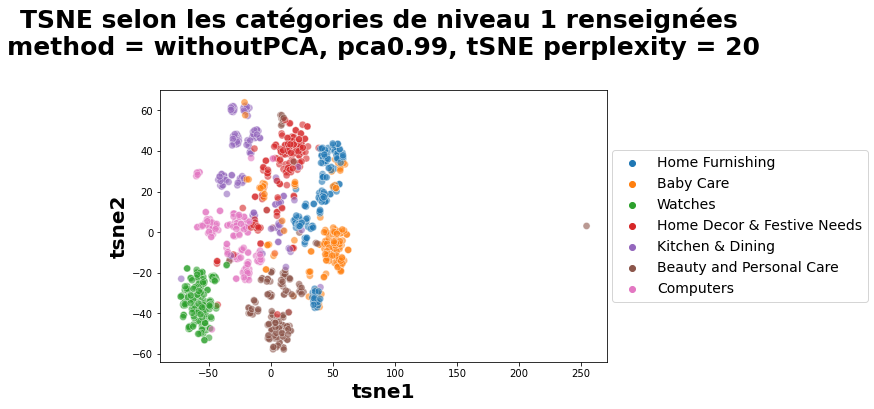

----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.28 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation of clustering


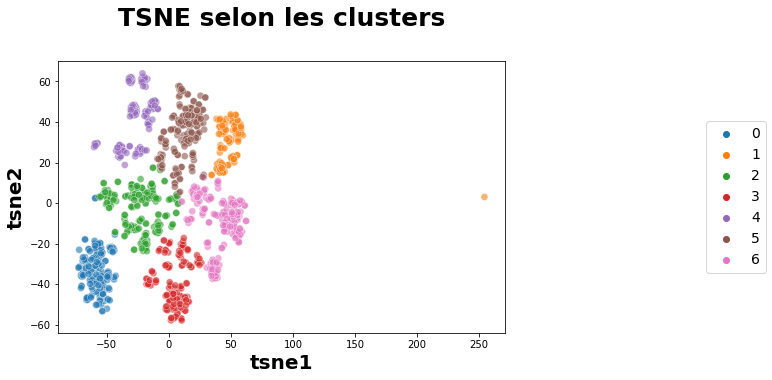

----------------------------------------------------------------------------------------------------
##### ARI calculation ...
ARI = 0.6260127631059773
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
total duration of the optimized run:            42.61 secondes


In [606]:
temps0 = time.time()

input_data = df_tfidf.iloc[:,1:4431]

# run PCA   
pca_var_expl = 0.99 # optimized value
print('-' * 100)  
print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
print("Dimensions dataset avant réduction PCA : ", input_data.shape)
temps1 = time.time() # to get PCA duration
pca = decomposition.PCA(n_components=pca_var_expl)
feat_data = pca.fit_transform(input_data)
### Creation of DF with PC and label categ1
desc_feat_pca99 = pd.DataFrame(feat_pca)
desc_feat_pca99 = desc_feat_pca99.add_prefix('desc_pca_feat_')
desc_feat_pca99["categ1"] = data.categ1
desc_feat_pca99['categ1_encoded'] = data.categ1_encoded
desc_feat_pca99.insert(0, "uniq_id", data.uniq_id)
#
duration1 = time.time() - temps1
print("Dimensions dataset après réduction PCA : ", feat_data.shape)
print("temps de traitement PCA : ", "%15.2f" % duration1, "secondes")

# Réduction dimensionnelle t-SNE              
perplexity = 20 # optimized value
print('-' * 100)
print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
temps2 = time.time() # to get t-SNE duration
tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                     n_iter=5000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_data)
# Création DF de dimension réduite via t-SNE avec label categ1
desc_feat_tsne2d20 = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
desc_feat_tsne2d20["categ1"] = data.categ1
desc_feat_tsne2d20["categ1_encoded"] = data.categ1_encoded
desc_feat_tsne2d20.insert(0, "uniq_id", data.uniq_id)
#
duration2 = time.time() - temps2
print("temps de traitement t-SNE : ", "%15.2f" % duration2, "secondes")

# Visual evaluation
print('-' * 100)
print('##### Visual evaluation through t-SNE plot')
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="categ1", data=desc_feat_tsne2d20, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
plt.title('TSNE selon les catégories de niveau 1 renseignées \n\
method = {}, pca{}, tSNE perplexity = {}'\
          .format(method, pca_var_expl, perplexity),
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5)) 
plt.show()

# clustering and visual evaluation
print('-' * 100)
print('##### Clustering from 2D t-SNE ...')
temps3 = time.time() # to get clustering duration
cls = cluster.KMeans(n_clusters=7, random_state=1)
cls.fit(X_tsne)
desc_feat_tsne2d20["cluster"] = cls.labels_
#
duration3 = time.time() - temps3
print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration3, "secondes")
# Visual evaluation
print('-' * 100)
print('##### Visual evaluation of clustering')
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=desc_feat_tsne2d20,
                legend="brief")
plt.title('TSNE selon les clusters',
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

# Calcul ARI
print('-' * 100)
print('##### ARI calculation ...')
labels = data.categ1_encoded
ARI = metrics.adjusted_rand_score(labels, cls.labels_)
print('ARI =', ARI)

#
print('-' * 100)
print('-' * 100)
duration4 = time.time() - temps0
print('total duration of the optimized run: ', "%15.2f" % duration4, "secondes")

### Matrice de confusion et graphes de répartition

In [607]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  0  88   0   0   0   3  59]
 [  0  12   6   3   4  15 110]
 [148   0   2   0   0   0   0]
 [  2   1  20   2   1 121   3]
 [  1   0  20   1 107  15   6]
 [  0   1   3 133   0  10   3]
 [  3   0 137   0   8   2   0]]


In [608]:
# non alignée donc alignement à la main
def conf_mat_transform(y_true,y_pred):
    '''Fonction de mise en correspondance
    entre labels vrais et clusters prédits
    dans la matrice de confusion'''
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    corresp = np.argmax(conf_mat, axis=0) # pas de pb de correspondance categ vraie-cluster pred
    # corresp = [1, 2, 0, 3, 4, 5, 6] # correspondance manuelle lorsque pb
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 0 6 5 4 3 1]
[[ 88  59   0   3   0   0   0]
 [ 12 110   0  15   4   3   6]
 [  0   0 148   0   0   0   2]
 [  1   3   2 121   1   2  20]
 [  0   6   1  15 107   1  20]
 [  1   3   0  10   0 133   3]
 [  0   0   3   2   8   0 137]]

              precision    recall  f1-score   support

           0       0.86      0.59      0.70       150
           1       0.61      0.73      0.66       150
           2       0.96      0.99      0.97       150
           3       0.73      0.81      0.77       150
           4       0.89      0.71      0.79       150
           5       0.96      0.89      0.92       150
           6       0.73      0.91      0.81       150

    accuracy                           0.80      1050
   macro avg       0.82      0.80      0.80      1050
weighted avg       0.82      0.80      0.80      1050



Text(0.5, 15.0, 'Predicted corresponding cluster')

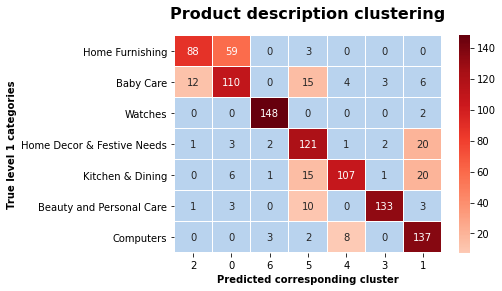

In [609]:
import copy

categ_list = []
for key, val in categ1_encoding.items():
    categ_list.append(key)
categ_list

df_cm2 = pd.DataFrame(conf_mat, index = [categ for categ in categ_list],
                     columns = [i for i in "2065431"])
plt.figure(figsize = (6,4))
plt.title('Product description clustering', fontweight='bold', fontsize=16, y=1.05)
cmap = copy.copy(plt.get_cmap("Reds"))
cmap.set_under('#B9D3EE')
sns.heatmap(df_cm2, annot=True, fmt='.0f', cmap=cmap, lw=0.005, center=60, vmin=150*0.05)
plt.ylabel('True level 1 categories', fontweight='bold')
plt.xlabel('Predicted corresponding cluster', fontweight='bold')

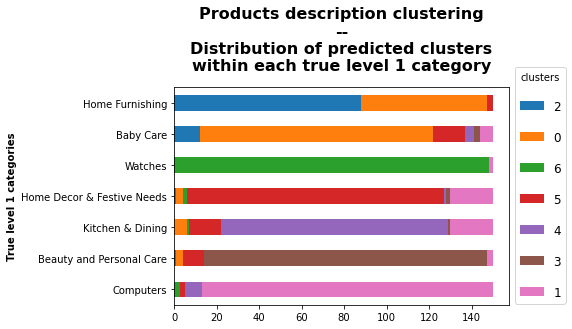

In [768]:
ax = df_cm2.plot.barh(stacked=True)
ax.set_title('Products description clustering\n--\nDistribution of predicted clusters\nwithin each true level 1 category',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_ylabel('True level 1 categories', fontweight='bold')
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.55),
          fontsize=12, labelspacing=1.5, title='clusters')

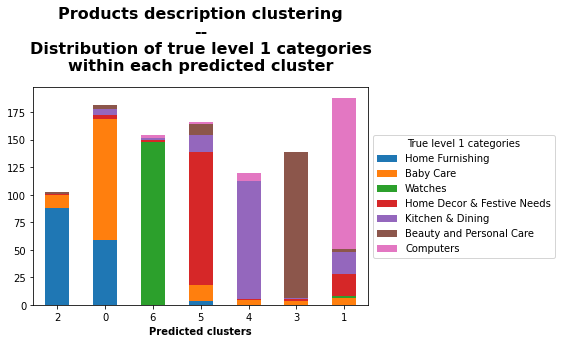

In [665]:
ax = df_cm2.T.plot.bar(stacked=True)
ax.set_title('Products description clustering\n--\nDistribution of true level 1 categories\nwithin each predicted cluster',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_xticklabels([i for i in "2065431"], rotation=0)
ax.set_xlabel('Predicted clusters', fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='True level 1 categories')

# Combinaison images + descriptions
Rappel des datasets :
* img_feat_pca99
* img_feat_tsne2d45
* desc_feat_pca99
* desc_feat_tsne2d20

In [393]:
# Export au format csv
img_feat_pca99.to_csv('img_feat_pca99')
img_feat_tsne2d45.to_csv('img_feat_tsne2d45')
desc_feat_pca99.to_csv('desc_feat_pca99')
desc_feat_tsne2d20.to_csv('desc_feat_tsne2d20')

In [394]:
# Recapitulatif
for df in [img_feat_pca99, img_feat_tsne2d45, desc_feat_pca99, desc_feat_tsne2d20]:
    print(df.shape)
    print(df.columns)
    print('-' * 20)

(1050, 886)
Index(['img_pca_feat_0', 'img_pca_feat_1', 'img_pca_feat_2', 'img_pca_feat_3',
       'img_pca_feat_4', 'img_pca_feat_5', 'img_pca_feat_6', 'img_pca_feat_7',
       'img_pca_feat_8', 'img_pca_feat_9',
       ...
       'img_pca_feat_876', 'img_pca_feat_877', 'img_pca_feat_878',
       'img_pca_feat_879', 'img_pca_feat_880', 'img_pca_feat_881',
       'img_pca_feat_882', 'categ1', 'categ1_encoded', 'uniq_id'],
      dtype='object', length=886)
--------------------
(1050, 6)
Index(['tsne1', 'tsne2', 'categ1', 'categ1_encoded', 'cluster', 'uniq_id'], dtype='object')
--------------------
(1050, 652)
Index(['uniq_id', 'desc_pca_feat_0', 'desc_pca_feat_1', 'desc_pca_feat_2',
       'desc_pca_feat_3', 'desc_pca_feat_4', 'desc_pca_feat_5',
       'desc_pca_feat_6', 'desc_pca_feat_7', 'desc_pca_feat_8',
       ...
       'desc_pca_feat_641', 'desc_pca_feat_642', 'desc_pca_feat_643',
       'desc_pca_feat_644', 'desc_pca_feat_645', 'desc_pca_feat_646',
       'desc_pca_feat_647', 'de

## préparation des données: merge des features images et descriptions issues des PCA

In [56]:
# merge des df issus des PCA sur features images et features descriptions
merge_pca_feat = pd.merge(img_feat_pca99, desc_feat_pca99)
merge_pca_feat.shape

(1050, 1535)

In [57]:
pd.set_option('display.max_columns', None)
merge_pca_feat.head(0)

Empty DataFrame
Columns: [img_pca_feat_0, img_pca_feat_1, img_pca_feat_2, img_pca_feat_3, img_pca_feat_4, img_pca_feat_5, img_pca_feat_6, img_pca_feat_7, img_pca_feat_8, img_pca_feat_9, img_pca_feat_10, img_pca_feat_11, img_pca_feat_12, img_pca_feat_13, img_pca_feat_14, img_pca_feat_15, img_pca_feat_16, img_pca_feat_17, img_pca_feat_18, img_pca_feat_19, img_pca_feat_20, img_pca_feat_21, img_pca_feat_22, img_pca_feat_23, img_pca_feat_24, img_pca_feat_25, img_pca_feat_26, img_pca_feat_27, img_pca_feat_28, img_pca_feat_29, img_pca_feat_30, img_pca_feat_31, img_pca_feat_32, img_pca_feat_33, img_pca_feat_34, img_pca_feat_35, img_pca_feat_36, img_pca_feat_37, img_pca_feat_38, img_pca_feat_39, img_pca_feat_40, img_pca_feat_41, img_pca_feat_42, img_pca_feat_43, img_pca_feat_44, img_pca_feat_45, img_pca_feat_46, img_pca_feat_47, img_pca_feat_48, img_pca_feat_49, img_pca_feat_50, img_pca_feat_51, img_pca_feat_52, img_pca_feat_53, img_pca_feat_54, img_pca_feat_55, img_pca_feat_56, img_pca_feat_57, img_pca_feat_58, img_pca_feat_59, img_pca_feat_60, img_pca_feat_61, img_pca_feat_62, img_pca_feat_63, img_pca_feat_64, img_pca_feat_65, img_pca_feat_66, img_pca_feat_67, img_pca_feat_68, img_pca_feat_69, img_pca_feat_70, img_pca_feat_71, img_pca_feat_72, img_pca_feat_73, img_pca_feat_74, img_pca_feat_75, img_pca_feat_76, img_pca_feat_77, img_pca_feat_78, img_pca_feat_79, img_pca_feat_80, img_pca_feat_81, img_pca_feat_82, img_pca_feat_83, img_pca_feat_84, img_pca_feat_85, img_pca_feat_86, img_pca_feat_87, img_pca_feat_88, img_pca_feat_89, img_pca_feat_90, img_pca_feat_91, img_pca_feat_92, img_pca_feat_93, img_pca_feat_94, img_pca_feat_95, img_pca_feat_96, img_pca_feat_97, img_pca_feat_98, img_pca_feat_99, ...]
Index: []

In [58]:
# move columns to get general info at the start
cols_at_start = ['uniq_id', 'categ1', 'categ1_encoded']
merge_pca_feat = merge_pca_feat[[c for c in cols_at_start if c in merge_pca_feat]
                                + [c for c in merge_pca_feat if c not in cols_at_start]]
print(merge_pca_feat.shape)
merge_pca_feat.head(0)

(1050, 1535)


Empty DataFrame
Columns: [uniq_id, categ1, categ1_encoded, img_pca_feat_0, img_pca_feat_1, img_pca_feat_2, img_pca_feat_3, img_pca_feat_4, img_pca_feat_5, img_pca_feat_6, img_pca_feat_7, img_pca_feat_8, img_pca_feat_9, img_pca_feat_10, img_pca_feat_11, img_pca_feat_12, img_pca_feat_13, img_pca_feat_14, img_pca_feat_15, img_pca_feat_16, img_pca_feat_17, img_pca_feat_18, img_pca_feat_19, img_pca_feat_20, img_pca_feat_21, img_pca_feat_22, img_pca_feat_23, img_pca_feat_24, img_pca_feat_25, img_pca_feat_26, img_pca_feat_27, img_pca_feat_28, img_pca_feat_29, img_pca_feat_30, img_pca_feat_31, img_pca_feat_32, img_pca_feat_33, img_pca_feat_34, img_pca_feat_35, img_pca_feat_36, img_pca_feat_37, img_pca_feat_38, img_pca_feat_39, img_pca_feat_40, img_pca_feat_41, img_pca_feat_42, img_pca_feat_43, img_pca_feat_44, img_pca_feat_45, img_pca_feat_46, img_pca_feat_47, img_pca_feat_48, img_pca_feat_49, img_pca_feat_50, img_pca_feat_51, img_pca_feat_52, img_pca_feat_53, img_pca_feat_54, img_pca_feat_55, img_pca_feat_56, img_pca_feat_57, img_pca_feat_58, img_pca_feat_59, img_pca_feat_60, img_pca_feat_61, img_pca_feat_62, img_pca_feat_63, img_pca_feat_64, img_pca_feat_65, img_pca_feat_66, img_pca_feat_67, img_pca_feat_68, img_pca_feat_69, img_pca_feat_70, img_pca_feat_71, img_pca_feat_72, img_pca_feat_73, img_pca_feat_74, img_pca_feat_75, img_pca_feat_76, img_pca_feat_77, img_pca_feat_78, img_pca_feat_79, img_pca_feat_80, img_pca_feat_81, img_pca_feat_82, img_pca_feat_83, img_pca_feat_84, img_pca_feat_85, img_pca_feat_86, img_pca_feat_87, img_pca_feat_88, img_pca_feat_89, img_pca_feat_90, img_pca_feat_91, img_pca_feat_92, img_pca_feat_93, img_pca_feat_94, img_pca_feat_95, img_pca_feat_96, ...]
Index: []

## réduction(s) dimensionnelle(s) + clustering avec optimisation

In [59]:
data_list = []
method_list = []
nb_reduced_dim_list = []

# hyperparam :
pca_expl_var_list = []
tsne_perplexity_list = []
tsne_init_list = []
ARI_list = []


temps0 = time.time()
data_type = 'pca_derived'
input_data = merge_pca_feat.iloc[:, 3:]

for method in ['withPCA', 'withoutPCA']:
    print('-' * 100)
    print("##### Run of method ##{}## ...".format(method))
    if method == 'withPCA':
        # run PCA  
        for pca_var_expl in [0.8, 0.9, 0.99]:
            print('-' * 100)  
            print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
            print("Dimensions dataset avant réduction PCA : ", input_data.shape)
            temps1 = time.time() # to get PCA duration
            ### PCA
            pca = decomposition.PCA(n_components=pca_var_expl)
            feat_data = pca.fit_transform(input_data)
            #
            duration1 = time.time() - temps1
            print("Dimensions dataset après réduction PCA : ", feat_data.shape)
            print("temps de traitement PCA : ", "%15.2f" % duration1, "secondes")
            
            nb_reduced_dim = feat_data.shape[1]

    # t-SNE and visual evaluation               
            for perplexity in [2,5,10,15,20,25,30,35,40,45,50,75,100,500]:
                print('-' * 100)
                print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
                temps2 = time.time() # to get t-SNE duration
            # Réduction dimensionnelle t-SNE
                init_met = 'random'
                tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                     n_iter=5000, init=init_met, random_state=6)
                X_tsne = tsne.fit_transform(feat_data)
                # Création DF de dimension réduite avec label categ1
                df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                df_tsne["categ1"] = data.categ1
                df_tsne["categ1_encoded"] = data.categ1_encoded
                #
                duration2 = time.time() - temps2
                print("temps de traitement t-SNE : ", "%15.2f" % duration2, "secondes")
            # Visual evaluation removed here

    # clustering and visual evaluation
                print('-' * 100)
                print('##### Clustering from 2D t-SNE ...')
                temps3 = time.time() # to get clustering duration
            # Clustering
                cls = cluster.KMeans(n_clusters=7, random_state=1)
                cls.fit(X_tsne)
                df_tsne["cluster"] = cls.labels_
                #
                duration3 = time.time() - temps3
                print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration3, "secondes")
            # Visual evaluation removed here

    # Calcul ARI
                print('-' * 100)
                print('##### ARI calculation ...')
                temps4 = time.time() # to get ARI calculation duration
                labels = data.categ1_encoded
                ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                #
                duration4 = time.time() - temps4
                print("temps de calcul ARI : ", "%15.2f" % duration4, "secondes")

    # Concatenation of hyperparameters and corresponding ARI results
                data_list.append(data_type)
                method_list.append(method)
                pca_expl_var_list.append(pca_var_expl)
                nb_reduced_dim_list.append(nb_reduced_dim)
                tsne_perplexity_list.append(perplexity)
                tsne_init_list.append(init_met)
                ARI_list.append(ARI)

    # process duration of each complete loop 
                duration5 = time.time() - temps1
                print('Temps de traitement de chaque boucle complète : ',
                  "%15.2f" % duration5, "secondes")                 
            
    if method == 'withoutPCA':
        pca_var_expl = np.nan
        nb_reduced_dim = input_data.shape[1]

# t-SNE and visual evaluation               
        for perplexity in [2,5,10,15,20,25,30,35,40,45,50,75,100,500]:
            print('-' * 100)
            print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
            for init_met in ['random', 'pca']:
                temps3 = time.time() # to get t-SNE duration
            # Réduction dimensionnelle t-SNE
                tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                                     n_iter=5000, init=init_met, random_state=6)
                X_tsne = tsne.fit_transform(np.array(input_data))
                # Création DF de dimension réduite avec label categ1
                df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
                df_tsne["categ1"] = data.categ1
                df_tsne["categ1_encoded"] = data.categ1_encoded
                #
                duration3 = time.time() - temps3
                print("temps de traitement t-SNE : ", "%15.2f" % duration3, "secondes")
            # Visual evaluation removed here

        # clustering and visual evaluation
                print('-' * 100)
                print('##### Clustering from 2D t-SNE ...')
                temps4 = time.time() # to get clustering duration
            # Clustering
                cls = cluster.KMeans(n_clusters=7, random_state=1)
                cls.fit(X_tsne)
                df_tsne["cluster"] = cls.labels_
                #
                duration4 = time.time() - temps4
                print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration4, "secondes")
            # Visual evaluation removed here

        # Calcul ARI
                print('-' * 100)
                print('##### ARI calculation ...')
                temps5 = time.time() # to get ARI calculation duration
                labels = data.categ1_encoded
                ARI = metrics.adjusted_rand_score(labels, cls.labels_)
                #
                duration5 = time.time() - temps5
                print("temps de calcul ARI : ", "%15.2f" % duration5, "secondes")

        # Concatenation of hyperparameters and corresponding ARI results
                data_list.append(data_type)
                method_list.append(method)
                pca_expl_var_list.append(pca_var_expl)
                nb_reduced_dim_list.append(nb_reduced_dim)
                tsne_perplexity_list.append(perplexity)
                tsne_init_list.append(init_met)
                ARI_list.append(ARI)

        # process duration of each complete loop 
                duration5 = time.time() - temps1
                print('Temps de traitement de chaque boucle complète : ',
                  "%15.2f" % duration5, "secondes")

# Creation of DF with results
results_dict3 = {'data_type': data_list,
                 'method': method_list,
                'pca_expl_var': pca_expl_var_list,
                'nb_reduced_dimensions': nb_reduced_dim_list,
                'tsne_perplexity': tsne_perplexity_list,
                'tsne_initialisation': tsne_init_list,
                'ARI': ARI_list}
results3 = pd.DataFrame(results_dict3)

print('min ARI = ', min(results3.ARI))
print('max ARI = ', max(results3.ARI))
print('mean ARI = ', results3.ARI.mean())
print('std_dev ARI = ', results3.ARI.std())

display(HTML(results3[results3.ARI == max(results3.ARI)].to_html()))

print('-' * 100)
print('-' * 100)
print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration7 = time.time() - temps0
print('total duration of optimization process: ', "%15.2f" % duration7, "secondes")

----------------------------------------------------------------------------------------------------
##### Run of method ##withPCA## ...
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##80.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 1532)
Dimensions dataset après réduction PCA :  (1050, 277)
temps de traitement PCA :             0.51 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.54 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.10 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :            11.17 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.10 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.19 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :            23.48 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :            42.52 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            22.13 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            64.80 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.07 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.20 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            77.08 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.92 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            98.17 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.40 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           112.70 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.33 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           125.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.75 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           139.08 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.34 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           150.56 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.59 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           163.29 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.86 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           184.29 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            22.20 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           206.67 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.24 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           227.07 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##90.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 1532)
Dimensions dataset après réduction PCA :  (1050, 452)
temps de traitement PCA :             0.68 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.01 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            18.85 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.99 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            34.99 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.98 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            55.11 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.70 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.20 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            76.01 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.31 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            88.46 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.06 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           100.68 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.07 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           121.93 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.36 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           135.47 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            28.59 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           164.23 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            12.97 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           177.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.45 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.18 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           193.97 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            21.25 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           215.36 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.84 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           242.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            26.20 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           268.68 secondes
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 1532)
Dimensions dataset après réduction PCA :  (1050, 799)
temps de traitement PCA :             0.60 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.09 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            19.87 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.30 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :            39.33 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.48 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            53.96 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.56 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            65.68 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.00 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :            80.86 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.88 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           101.90 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.17 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           121.25 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.16 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           141.56 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.47 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           159.18 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.33 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.19 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           177.71 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            20.77 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           198.62 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            33.65 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           232.42 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           252.37 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.74 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           267.25 secondes
----------------------------------------------------------------------------------------------------
##### Run of method ##withoutPCA## ...
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##2## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            15.77 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           283.15 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            16.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.11 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           299.77 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##5## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.53 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           316.44 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            17.04 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           333.62 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##10## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            16.87 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           350.62 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            13.83 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           364.58 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##15## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.27 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           378.00 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.81 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           396.94 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##20## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            10.27 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           407.35 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            20.50 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           428.00 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##25## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.78 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           446.93 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            24.39 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.12 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           471.46 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##30## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            14.21 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           485.83 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            11.62 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           497.60 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##35## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            11.42 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           509.17 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            18.26 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           527.57 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##40## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            19.66 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           547.36 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            11.19 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.13 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           558.68 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            18.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           577.43 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            34.60 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.16 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           612.19 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##50## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            23.49 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           635.86 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            36.02 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.14 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           672.04 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##75## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            13.32 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.23 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           685.60 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            44.22 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.18 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           730.02 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##100## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            32.13 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           762.30 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            52.26 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.01 secondes
Temps de traitement de chaque boucle complète :           814.73 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##500## ...


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de traitement t-SNE :            17.21 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.15 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           832.10 secondes


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temps de traitement t-SNE :            84.37 secondes
----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.17 secondes
----------------------------------------------------------------------------------------------------
##### ARI calculation ...
temps de calcul ARI :             0.00 secondes
Temps de traitement de chaque boucle complète :           916.65 secondes
min ARI =  0.21517088272391555
max ARI =  0.44373554864216014
mean ARI =  0.3384578074084165
std_dev ARI =  0.0564530937259956


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration of optimization process:          1412.43 secondes


## BILAN IMG+DESC
Pas mieux qu'en utilisant les images seules
### Run méthode optimisée

----------------------------------------------------------------------------------------------------
##### Run of method ##withoutPCA## ...
----------------------------------------------------------------------------------------------------
##### PCA reduction with ##99.0%## of explained variance ...
Dimensions dataset avant réduction PCA :  (1050, 1532)
Dimensions dataset après réduction PCA :  (1050, 799)
temps de traitement PCA :             1.24 secondes
----------------------------------------------------------------------------------------------------
##### t-SNE reduction with perplexity of ##45## ...
temps de traitement t-SNE :            41.81 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation through t-SNE plot


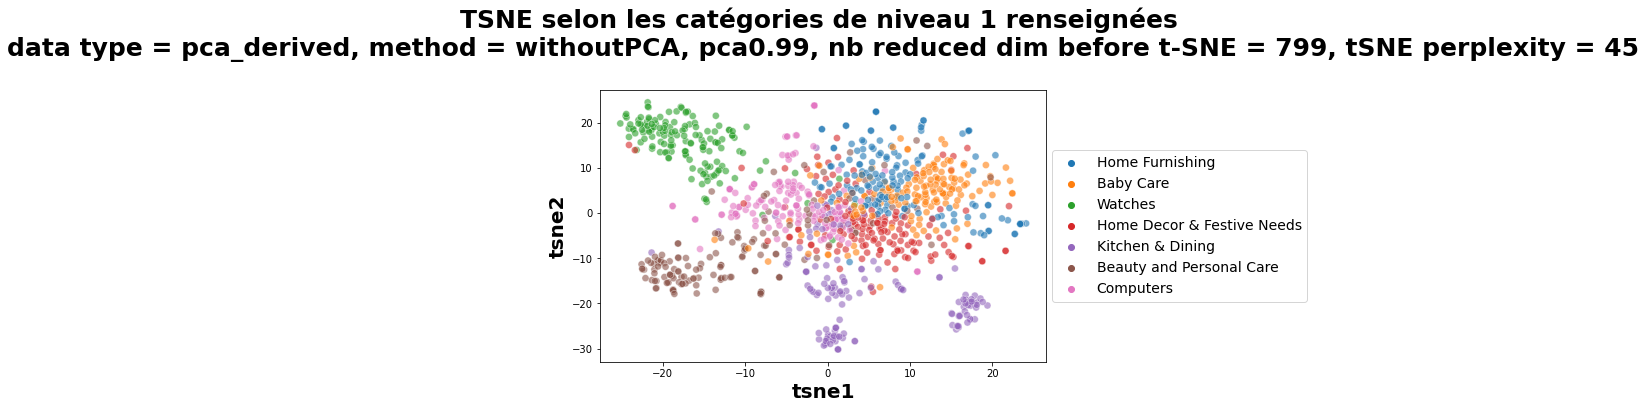

----------------------------------------------------------------------------------------------------
##### Clustering from 2D t-SNE ...
temps de traitement clustering sur t-SNE :             0.29 secondes
----------------------------------------------------------------------------------------------------
##### Visual evaluation of clustering


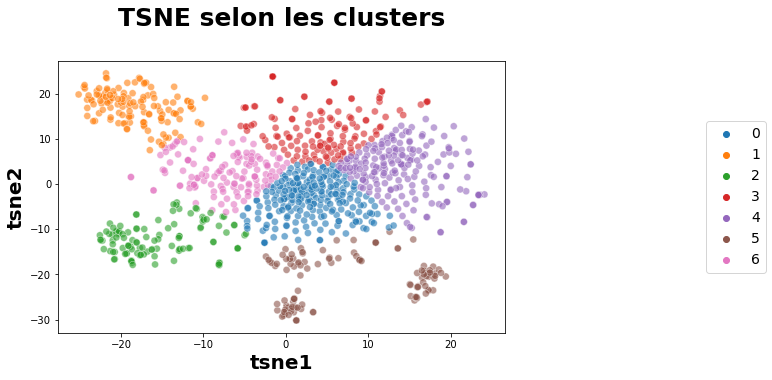

----------------------------------------------------------------------------------------------------
##### ARI calculation ...
ARI : 0.42643644114472357
##### END OF 'OPTIMIZATION' PROCESS #####
----------------------------------------------------------------------------------------------------
total duration of optimized run:            44.66 secondes


In [541]:
temps0 = time.time()
data_type = 'pca_derived'
input_data = merge_pca_feat.iloc[:, 3:]

print('-' * 100)
print("##### Run of method ##{}## ...".format(method))

# run PCA  
pca_var_expl = 0.99
print('-' * 100)  
print("##### PCA reduction with ##{}%## of explained variance ...".format(pca_var_expl*100))
print("Dimensions dataset avant réduction PCA : ", input_data.shape)
temps1 = time.time() # to get PCA duration
pca = decomposition.PCA(n_components=pca_var_expl)
feat_data = pca.fit_transform(input_data)
duration1 = time.time() - temps1
print("Dimensions dataset après réduction PCA : ", feat_data.shape)
print("temps de traitement PCA : ", "%15.2f" % duration1, "secondes")

nb_reduced_dim = feat_data.shape[1]

# run t-SNE
perplexity = 45
init_met = 'random'
print('-' * 100)
print('##### t-SNE reduction with perplexity of ##{}## ...'.format(perplexity))
temps2 = time.time() # to get t-SNE duration
tsne = manifold.TSNE(n_components=2, perplexity=perplexity, 
                     n_iter=5000, init=init_met, random_state=6)
X_tsne = tsne.fit_transform(feat_data)
# Création DF de dimension réduite avec label categ1
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["categ1"] = data.categ1
df_tsne["categ1_encoded"] = data.categ1_encoded
#
duration2 = time.time() - temps2
print("temps de traitement t-SNE : ", "%15.2f" % duration2, "secondes")

# Visual evaluation
print('-' * 100)
print('##### Visual evaluation through t-SNE plot')
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="categ1", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
plt.title('TSNE selon les catégories de niveau 1 renseignées \n\
data type = {}, method = {}, pca{}, nb reduced dim before t-SNE = {}, tSNE perplexity = {}'\
          .format(data_type, method, pca_var_expl, nb_reduced_dim, perplexity),
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5)) 
plt.show()

# clustering
print('-' * 100)
print('##### Clustering from 2D t-SNE ...')
temps3 = time.time() # to get clustering duration
cls = cluster.KMeans(n_clusters=7, random_state=1)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
duration3 = time.time() - temps3
print("temps de traitement clustering sur t-SNE : ", "%15.2f" % duration3, "secondes")

# Visual evaluation
print('-' * 100)
print('##### Visual evaluation of clustering')
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")
plt.title('TSNE selon les clusters',
          fontsize = 25, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 20, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 20, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

# Calcul ARI
print('-' * 100)
print('##### ARI calculation ...')
labels = data.categ1_encoded
ARI = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI :", ARI)

print('##### END OF \'OPTIMIZATION\' PROCESS #####')
print('-' * 100)
duration4 = time.time() - temps0
print('total duration of optimized run: ', "%15.2f" % duration4, "secondes")

### Matrice de confusion et graphes de répartition

In [771]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 19   0   0  79  49   0   3]
 [ 24   0   3  14 106   1   2]
 [  2 128   0   1   0   0  19]
 [ 97   2   0  15  24   4   8]
 [ 31   0   4   1   0 112   2]
 [ 17   0 108   7   4   0  14]
 [ 36   0   1  22   0   3  88]]


In [772]:
# non alignée donc alignement à la main
def conf_mat_transform(y_true,y_pred):
    '''Fonction de mise en correspondance
    entre labels vrais et clusters prédits
    dans la matrice de confusion'''
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    corresp = np.argmax(conf_mat, axis=0) # pas de pb de correspondance categ vraie-cluster pred
    # corresp = [1, 2, 0, 3, 4, 5, 6] # correspondance manuelle lorsque pb
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3 2 5 0 1 4 6]
[[ 79  49   0  19   0   0   3]
 [ 14 106   0  24   1   3   2]
 [  1   0 128   2   0   0  19]
 [ 15  24   2  97   4   0   8]
 [  1   0   0  31 112   4   2]
 [  7   4   0  17   0 108  14]
 [ 22   0   0  36   3   1  88]]

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       150
           1       0.58      0.71      0.64       150
           2       0.98      0.85      0.91       150
           3       0.43      0.65      0.52       150
           4       0.93      0.75      0.83       150
           5       0.93      0.72      0.81       150
           6       0.65      0.59      0.62       150

    accuracy                           0.68      1050
   macro avg       0.72      0.68      0.70      1050
weighted avg       0.72      0.68      0.70      1050



Text(0.5, 15.0, 'Predicted corresponding cluster')

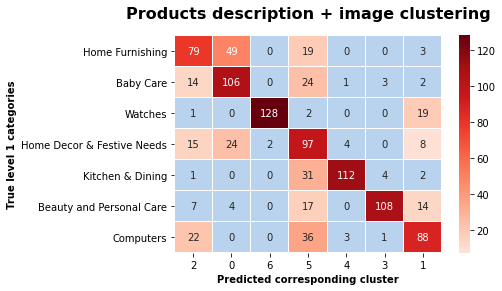

In [773]:
import copy

categ_list = []
for key, val in categ1_encoding.items():
    categ_list.append(key)
categ_list

df_cm3 = pd.DataFrame(conf_mat, index = [categ for categ in categ_list],
                     columns = [i for i in "2065431"])
plt.figure(figsize = (6,4))
plt.title('Products description + image clustering', fontweight='bold', fontsize=16, y=1.05)
cmap = copy.copy(plt.get_cmap("Reds"))
cmap.set_under('#B9D3EE')
sns.heatmap(df_cm3, annot=True, fmt='.0f', cmap=cmap, lw=0.005, center=60, vmin=150*0.05)
plt.ylabel('True level 1 categories', fontweight='bold')
plt.xlabel('Predicted corresponding cluster', fontweight='bold')

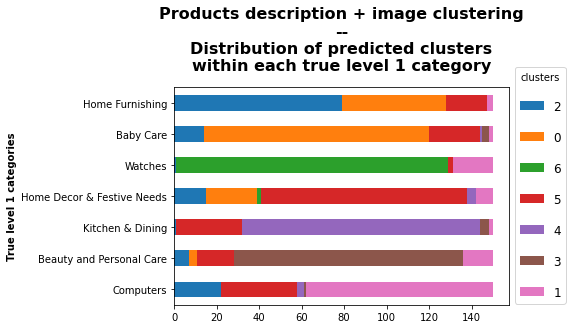

In [774]:
ax = df_cm3.plot.barh(stacked=True)
ax.set_title('Products description + image clustering\n--\nDistribution of predicted clusters\nwithin each true level 1 category',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_ylabel('True level 1 categories', fontweight='bold')
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.55),
          fontsize=12, labelspacing=1.5, title='clusters')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels),
#          loc='center left', bbox_to_anchor=(1, 0.55),
#          fontsize=12, labelspacing=1.5, title='clusters')

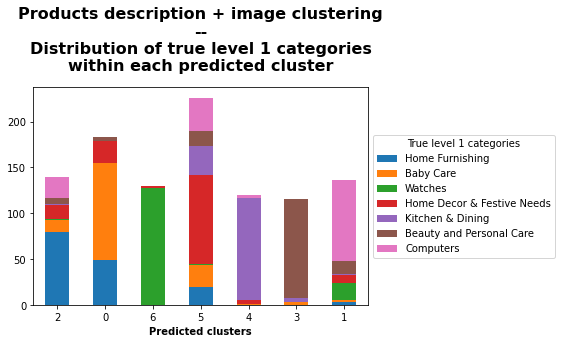

In [775]:
ax = df_cm3.T.plot.bar(stacked=True)
ax.set_title('Products description + image clustering\n--\nDistribution of true level 1 categories\nwithin each predicted cluster',
             fontweight='bold', fontsize=16, y=1.05)
ax.set_xticklabels([i for i in "2065431"], rotation=0)
ax.set_xlabel('Predicted clusters', fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='True level 1 categories')

# Comparaison des ARI de chaque méthode

In [785]:
CompARI_1 = pd.DataFrame(results2.groupby('method')['ARI'].max())
CompARI_1['data_type'] = 'descriptions'
CompARI_1.rename(columns={'ARI':'best_ARI'}, inplace=True)
CompARI_1

best_ARI     data_type
method                               
BoW            0.403316  descriptions
Word2Vec       0.195521  descriptions
bigrams_tfidf  0.304894  descriptions
tfidf          0.626013  descriptions

In [790]:
method = ['SIFT', 'vgg16_v1', 'vgg16_v2', 'vgg16_v2+tfidf']
best_ARI = [0.075754, 0.35298, 0.424437, 0.426436]
data_type = ['images', 'images', 'images', 'images+descriptions']
CompARI_2 = pd.DataFrame(list(zip(method, best_ARI, data_type)),
               columns =['method', 'best_ARI', 'data_type'])
CompARI_2.set_index('method', inplace=True)
CompARI_2

best_ARI            data_type
method                                       
SIFT            0.075754               images
vgg16_v1        0.352980               images
vgg16_v2        0.424437               images
vgg16_v2+tfidf  0.426436  images+descriptions

In [791]:
CompARI = pd.concat([CompARI_1, CompARI_2])
CompARI

best_ARI            data_type
method                                       
BoW             0.403316         descriptions
Word2Vec        0.195521         descriptions
bigrams_tfidf   0.304894         descriptions
tfidf           0.626013         descriptions
SIFT            0.075754               images
vgg16_v1        0.352980               images
vgg16_v2        0.424437               images
vgg16_v2+tfidf  0.426436  images+descriptions

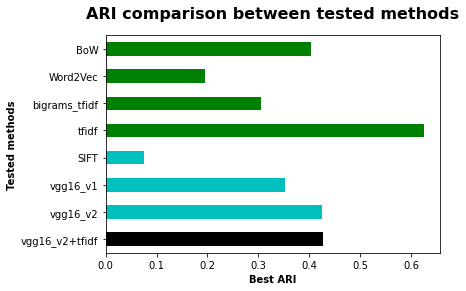

In [802]:
colors = {'descriptions': 'g', 'images': 'c', 'images+descriptions': 'k'}
fig = CompARI['best_ARI'].plot(kind='barh', color=[colors[i] for i in CompARI['data_type']])
fig.set_title('ARI comparison between tested methods',
             fontweight='bold', fontsize=16, y=1.05)
fig.set_ylabel('Tested methods', fontweight='bold')
fig.set_xlabel('Best ARI', fontweight='bold')
fig.invert_yaxis()

In [534]:
def sizeof_fmt(num, suffix='B'):
    '''from: https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          _242:  1.4 GiB
            sift_keypoints_all: 646.5 MiB
              df_tfidf_bigrams: 128.4 MiB
                          _362: 128.4 MiB
                          _370: 128.4 MiB
                            X2: 128.2 MiB
                          _364: 127.0 MiB
                          _366: 126.2 MiB
                          _368: 126.2 MiB
                        df_BoW: 35.7 MiB
